# Uber Nairobi Ambulance Perambulation Challenge

# Can you use ML to create an optimised ambulance deployment strategy in Nairobi?

# Upvote this Kernel if you find it useful. 
# More of these are coming to share and to learn from.

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. 

We are challenged to determine locations to position 6 ambulances that will minimize the distance to recorded accidents. Train data contains an accident datetime with the associated latitude and longitude of the accident location between 2018 to early 2019.

While test set contains the accident datetime without the associated latitude and longitude. In order to build a useful model, we need a way to evaluate for each datetime and locations, the probability of an accident occuring in order to recommend ambulance locations for a 3hrs duration.

We approach the problem by checking our score when we position our ambulances randomly in train data, then position our ambulances at the accident hotspots in train data. We compare the performance then optimize the distance using gradient descent.

The solution utilizes the optimized static locations from gradient descent and shifts the locations in reponse to different external conditions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uber-nairobi-ambulance-data/Train (67).csv
/kaggle/input/uber-nairobi-ambulance-data/segments_geometry.geojson
/kaggle/input/uber-nairobi-ambulance-data/Segment_info.csv
/kaggle/input/uber-nairobi-ambulance-data/Weather_Nairobi_Daily_GFS.csv
/kaggle/input/uber-nairobi-ambulance-data/SampleSubmission (45).csv


# Overview of Notebook

The goal of this notebook is to create an optimized ambulance positioning deployment from first optimizing static locations using all the accident locations. We further finetune this static locations in response to external conditions, utilizing cross-validation to judge performance of fine-tuning on certain conditions. 

The idea is for certain conditions, the ambulances can be positioned differently. Not all conditions favour a different positioning but we identify conditions worth optimizing for using a cross-validation approach.

In [2]:
pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 418 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install swifter
!pip install bayesian-optimization
!pip install scikit-optimize

     |████████████████████████████████| 633 kB 413 kB/s eta 0:00:01
     |████████████████████████████████| 564 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 17.2 MB 10.1 MB/s eta 0:00:01


  Created wheel for swifter: filename=swifter-1.0.7-py3-none-any.whl size=13977 sha256=64c80f40c08ff457121c5b8379e8be0fe1a6d311d37bfbd41064903f15d6a04b
  Stored in directory: /root/.cache/pip/wheels/49/44/5b/2c3fcb044734cb9969adbeeab8de419e571fb3d9d0b9f62dae
Successfully built swifter
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.4
    Uninstalling pandas-1.1.4:
      Successfully uninstalled pandas-1.1.4
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 1.0.1
    Uninstalling pyarrow-1.0.1:
      Successfully uninstalled pyarrow-1.0.1


In [4]:
import numpy as np
import pandas as pd
import random
seed = 777
random.seed(seed)
np.random.seed(seed)

In [5]:
#Analysis and data preparation

import math
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np  
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import permutations
from tqdm import tqdm
import swifter
from itertools import combinations
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import operator
import os
import warnings
import pandas as pd
# import geopandas as gpd # For loading the map of road segments


#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (20,15)     
# warnings.filterwarnings('ignore')
# from typing import List

#building models
import lightgbm as lgb
import xgboost as xgb
import tensorflow as tf
import torch
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, \
KFold, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from torch import tensor



import time
import sys

#metrics 
from sklearn.metrics import balanced_accuracy_score, auc, mean_squared_error, roc_curve, confusion_matrix, precision_score, recall_score, f1_score,\
log_loss, roc_auc_score
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch import nn
from collections import OrderedDict


#Clustering

from sklearn.cluster import KMeans

# #import shap
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Load the data
df = pd.read_csv('/kaggle/input/uber-nairobi-ambulance-data/Train (67).csv', parse_dates=['datetime'])
print(df.shape)
df.head(10)

rand = 303


(6318, 4)


### DATA OVERVIEW:

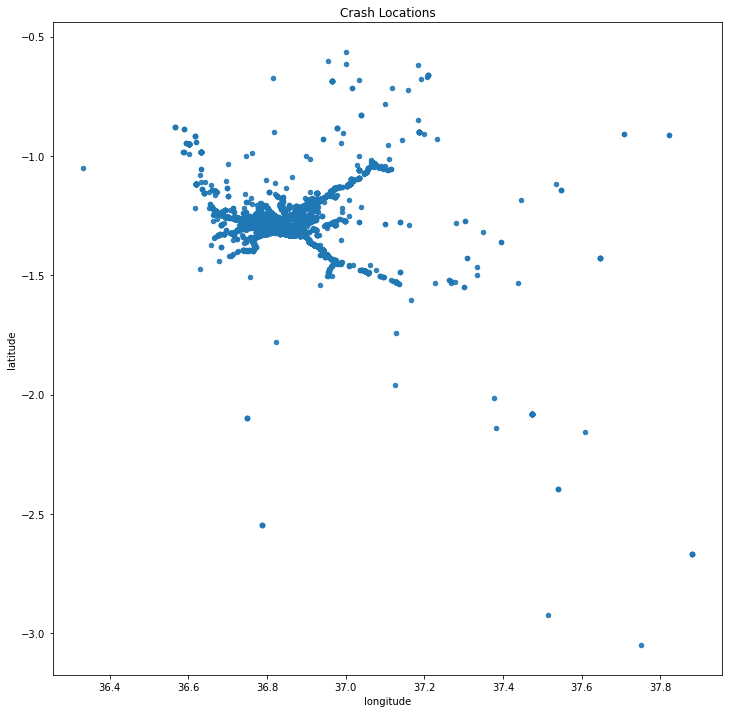

In [7]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.9, title='Crash Locations')

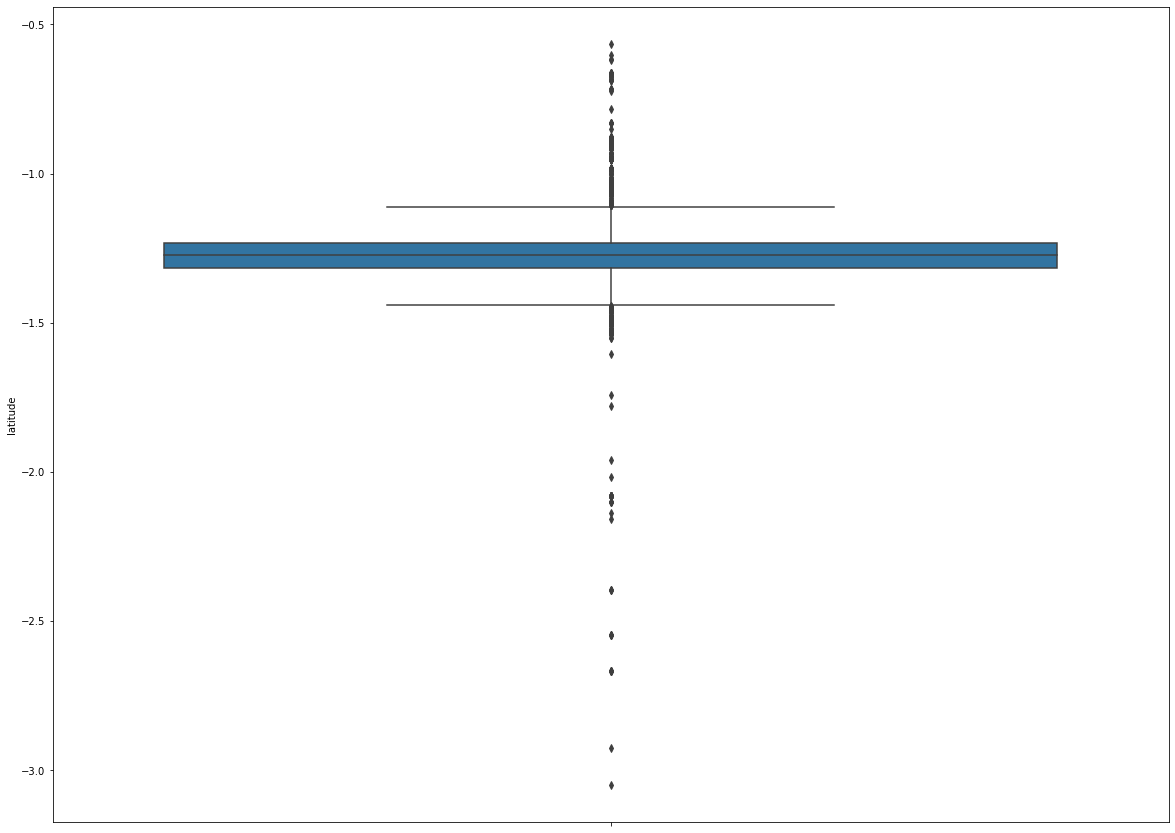

In [8]:
sns.boxplot(y = 'latitude', data = df)

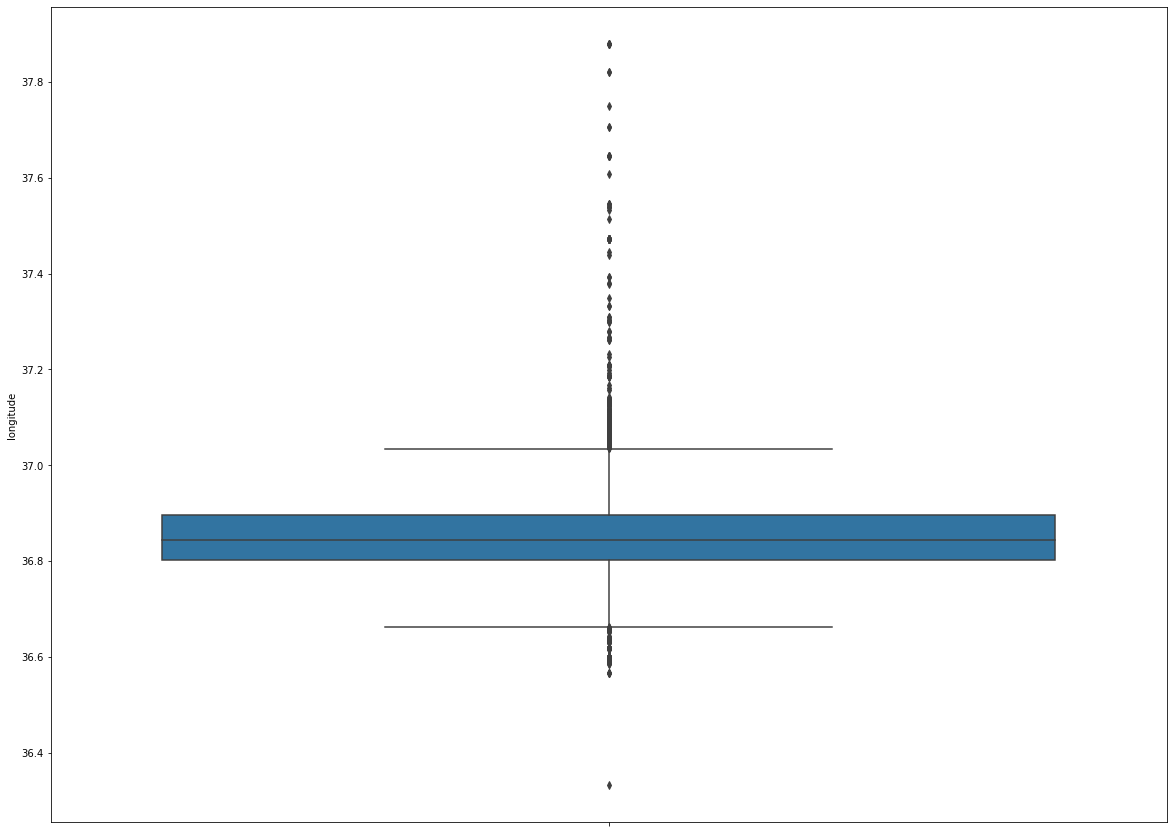

In [9]:
sns.boxplot(y = 'longitude', data = df)

From the plot, most accidents are concentrated at Longitude 36.8-37.0 (Centered around 36.9) and Latitude -1.25 to -1.29


Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

### Build Baseline Model: Building baseline model of determining static locations not dependent on external factors 
### and optimzing static distance to accident locations in train data.

In [10]:
# View the submission format
ss = pd.read_csv('/kaggle/input/uber-nairobi-ambulance-data/SampleSubmission (45).csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
ss.columns

Index(['date', 'A0_Latitude', 'A0_Longitude', 'A1_Latitude', 'A1_Longitude',
       'A2_Latitude', 'A2_Longitude', 'A3_Latitude', 'A3_Longitude',
       'A4_Latitude', 'A4_Longitude', 'A5_Latitude', 'A5_Longitude'],
      dtype='object')

# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [12]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values: #For each accident period in the test set
        
        row = sub.loc[sub.date < date].tail(1) #The closest ambulance schedule 
        #time is picked
        
        dists = [] 
        for a in range(6):
            dist = (((c_lat - row[f'A{a}_Latitude'].values[0])**2)+((c_lon - row[f'A{a}_Longitude'].values[0])**2))**0.5 
            #the distance from lat, long is calulated for 6 ambulances
            
            dists.append(dist) 
        total_distance += min(dists) #the closest ambulance is addeed to the overall distance
    return total_distance


In [13]:
df.describe()

,uid,latitude,longitude
count,6318.000000,6318.000000,6318.000000
mean,3159.500000,-1.270338,36.855459
std,1823.993832,0.125157,0.112866
min,1.000000,-3.050000,36.332202
25%,1580.250000,-1.316585,36.802048
50%,3159.500000,-1.271709,36.844591
75%,4738.750000,-1.233746,36.895642
max,6318.000000,-0.565402,37.879490


In [14]:
weather = pd.read_csv('/kaggle/input/uber-nairobi-ambulance-data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


In [15]:
#Fill using forward fill

weather = weather.fillna(method = 'ffill')

In [16]:
def bin_weather(df, col):
    
    bins = np.linspace(min(df[col]), max(df[col]), 4)

    group_names = ['low', 'mid', 'high']

    df[col + '-bin'] = pd.cut(df[col], bins, labels = group_names, include_lowest = True)
    


In [17]:
weather.columns

Index(['Date', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground'],
      dtype='object')

In [18]:
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


In [19]:
for feature in weather.columns:
    
    if feature != 'Date':
    
        bin_weather(weather, feature)

In [20]:
df['Date'] = df['datetime'].dt.date

weather['Date'] = weather['Date'].astype(str)

df['Date'] = df['Date'].astype(str)

#merge weather data

df = pd.merge(df, weather, on= ['Date'],  how='left')

In [21]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date range covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# # Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:

    if ambulance == 0: 
        
        sub['A'+str(ambulance)+'_Latitude'] = -1.23
        sub['A'+str(ambulance)+'_Longitude'] = 36.8
        
    else:
        sub['A'+str(ambulance)+'_Latitude'] =  sub['A'+str(ambulance-1)+'_Latitude'] - 0.05
        sub['A'+str(ambulance)+'_Longitude'] = sub['A'+str(ambulance-1)+'_Longitude'] + 0.05





score(sub, reference)


143.32901362115587

In [22]:

sub['Date'] = sub['date'].dt.date.astype(str)

#merge weather data

sub = pd.merge(sub, weather, on= ['Date'],  how='left')


# Testing our scoring function: Positioning the ambulances at 6 locations around center of the street

In [23]:
sub.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,...,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere-bin,relative_humidity_2m_above_ground-bin,specific_humidity_2m_above_ground-bin,temperature_2m_above_ground-bin,u_component_of_wind_10m_above_ground-bin,v_component_of_wind_10m_above_ground-bin
0,2019-01-01 00:00:00,-1.23,36.8,-1.28,36.85,-1.33,36.9,-1.38,36.95,-1.43,...,0.01032,13.913171,-2.628098,-3.06291,mid,high,mid,low,mid,low
1,2019-01-01 03:00:00,-1.23,36.8,-1.28,36.85,-1.33,36.9,-1.38,36.95,-1.43,...,0.01032,13.913171,-2.628098,-3.06291,mid,high,mid,low,mid,low
2,2019-01-01 06:00:00,-1.23,36.8,-1.28,36.85,-1.33,36.9,-1.38,36.95,-1.43,...,0.01032,13.913171,-2.628098,-3.06291,mid,high,mid,low,mid,low
3,2019-01-01 09:00:00,-1.23,36.8,-1.28,36.85,-1.33,36.9,-1.38,36.95,-1.43,...,0.01032,13.913171,-2.628098,-3.06291,mid,high,mid,low,mid,low
4,2019-01-01 12:00:00,-1.23,36.8,-1.28,36.85,-1.33,36.9,-1.38,36.95,-1.43,...,0.01032,13.913171,-2.628098,-3.06291,mid,high,mid,low,mid,low


In [24]:
#Create time features

df['3h'] = (df.datetime.dt.hour  / 3).astype(int)* 3 

sub['3h'] = (sub.date.dt.hour  / 3).astype(int)* 3 

df['year'] = df.datetime.dt.year

sub['year'] = sub.date.dt.year

df['weekend/week'] = (df.datetime.dt.dayofweek//5 == 1).astype('float')

sub['weekend/week'] = (sub.date.dt.dayofweek//5 == 1).astype('float')

df['dayofweek'] = df.datetime.dt.dayofweek

sub['dayofweek'] = sub.date.dt.dayofweek

df['month'] = df.datetime.dt.month

sub['month'] = sub.date.dt.month



In [25]:
df['year']

0       2018
1       2018
2       2018
3       2018
4       2018
        ... 
6313    2019
6314    2019
6315    2019
6316    2019
6317    2019
Name: year, Length: 6318, dtype: int64

# Finding static locations with Gradient Descent (Baseline Approach) 

Credits: JonathanWhitaker

To do the gradient descent we'll rely on PyTorch to calculate gradients. If you're not familiar with tensors and this part looks scary, check out the fastai lossons that cover SGD from scratch (Lessons 3 and 4 of the new course and this book chapter:https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb). This is where I got a lot of the inspiration for this code.

I start with 6 random locations that are close to the center of the crashes - plot these over the crashes and see if this initialization seems sensible.

In [26]:
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.02  # 6 pairs of random numbers, made fairly small
amb_locs = amb_locs + tensor((-1.27, 36.85)) # Centered around the middle of town
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations


tensor([[-1.2956, 36.8537],
        [-1.2542, 36.8743],
        [-1.2514, 36.8665],
        [-1.2404, 36.8395],
        [-1.2824, 36.8783],
        [-1.3063, 36.8479]], requires_grad=True)

In [27]:
# Crash locations - turn the training data into a tensor we can work with
crash_locs = tensor(df[['latitude', 'longitude']].values) # To Tensor

crash_locs = crash_locs.type('torch.FloatTensor')

len(crash_locs)

6318

In [28]:
def loss_fn(crash_locs, amb_locs):
  """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
  # Dists to first ambulance
  total_dists = []
  dists_split = crash_locs-amb_locs[0]
  dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
  min_dists = dists
  for i in range(1, 6):
    # Update dists so they represent the dist to the closest ambulance
    dists_split = crash_locs-amb_locs[i]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists = torch.min(min_dists, dists)
  
  return min_dists.mean()

In [29]:
# Calculate loss:
loss = loss_fn(crash_locs, amb_locs)
loss

tensor(0.0870, grad_fn=<MeanBackward0>)

In [30]:
# We can use .backward to find gradients
loss.backward()

In [31]:
# View gradients - they've been calculated for us!!!
amb_locs.grad

tensor([[-0.0280,  0.0497],
        [-0.1357, -0.1096],
        [-0.0255,  0.0169],
        [ 0.0498,  0.1703],
        [ 0.0499, -0.0442],
        [ 0.1191,  0.0896]])

These gradients tell us which way to move the locations to reduce the loss. This is all we need to do some gradient descent! We'll pick a learning rate, and then run through 1000 steps, updating the locations each time:

# Stochastic Gradient Descent and a Validation Set

We can train with mini-batches (SGD) to speed things up. We'll also use the 2019 crashes as a validation set and track how well we do on that over time. 

In [32]:
df.columns

Index(['uid', 'datetime', 'latitude', 'longitude', 'Date',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere-bin',
       'relative_humidity_2m_above_ground-bin',
       'specific_humidity_2m_above_ground-bin',
       'temperature_2m_above_ground-bin',
       'u_component_of_wind_10m_above_ground-bin',
       'v_component_of_wind_10m_above_ground-bin', '3h', 'year',
       'weekend/week', 'dayofweek', 'month'],
      dtype='object')

Helper Functions: For data extraction and training-

In [33]:
def extract_condition(data_df, cat, condition, kind_num, cat_2, condition_2, cat_3, condition_3):
    
    if kind_num == 'single':
    
        data_cat = data_df[data_df[cat].isin (condition)]
        data_cat = tensor(data_cat[['latitude', 'longitude']].values) # To Tensor
        data_cat = data_cat.type('torch.FloatTensor')
        
    elif kind_num == 'double':
        
        data_cat = data_df[(data_df[cat] == condition) & (data_df[cat_2] == condition_2)]
        data_cat = tensor(data_cat[['latitude', 'longitude']].values) # To Tensor
        data_cat = data_cat.type('torch.FloatTensor')
        
    else:
        
        data_cat = data_df[(data_df[cat] == condition) & (data_df[cat_2] == condition_2) & (data_df[cat_3] == condition_3)]
        data_cat = tensor(data_cat[['latitude', 'longitude']].values) # To Tensor
        data_cat = data_cat.type('torch.FloatTensor')
        
        
        
    return data_cat

In [34]:
def extract_data(df, cat, condition, kind, kind_num = 'single', cat_2 = 1 , condition_2 = 1, cat_3 = 1, condition_3 = 1):
    
    
        if kind == 'train':
    
            data_df = df[(df.datetime < '2019-01-01')]
            
            
        elif kind == 'dynamic':
            
            data_df = df
            
        
        else:
            
            data_df = df[(df.datetime > '2019-01-01')]
            
                              
        data_cat = extract_condition(data_df, cat, condition, kind_num, cat_2, condition_2, cat_3, condition_3)
        
                             
        return data_cat

In [35]:
def training_routine(train_locs, val_locs, learn_rate, epochs, amb_locs, shuffle_type):
        
    # Load crash locs from train into a dataloader
    dl = DataLoader(train_locs, batch_size= 64, shuffle= shuffle_type)
        
    amb_locs.requires_grad_()

    lr = learn_rate
    
    n_epochs = epochs

    # Store loss over time
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(n_epochs):
        # Run through batches
        for crashes in dl:
            loss = loss_fn(crashes, amb_locs) # Find loss for this batch of crashes
            loss.backward() # Calc grads
    
            amb_locs.data -= lr * amb_locs.grad.data # Update locs
            amb_locs.grad = None # Reset gradients for next step
            
                
            train_loss = loss_fn(train_locs, amb_locs).item()
                
            val_loss = loss_fn(val_locs, amb_locs).item()
            

                
            train_losses.append(loss_fn(train_locs, amb_locs).item())
            val_losses.append(loss_fn(val_locs, amb_locs).item()) 

        # Print validation loss

        print('Epoch : {}... Train loss: {:4f}... Val loss : {:4f}...'.\
              format(epoch, train_loss, val_loss))
        
    return amb_locs, train_losses, val_losses

# Static Ambulance positioning

In [36]:
#Train on 2018, validate on 2019 for static locations


torch.manual_seed(rand)
    
amb_locs = torch.randn(6, 2) * 0.02
amb_locs = amb_locs + tensor((-1.27, 36.85))


# Set up ambulance locations


    
all_df = list(df['3h'].unique())

train_locs = extract_data(df, '3h', all_df, 'train')

val_locs = extract_data(df, '3h', all_df, 'val')
    
amb_locs, train_losses, val_losses = training_routine(train_locs, val_locs, 0.003, 185, amb_locs, shuffle_type = True)       

Epoch : 0... Train loss: 0.074284... Val loss : 0.063902...
Epoch : 1... Train loss: 0.070080... Val loss : 0.060079...
Epoch : 2... Train loss: 0.068670... Val loss : 0.058859...
Epoch : 3... Train loss: 0.067998... Val loss : 0.058271...
Epoch : 4... Train loss: 0.065910... Val loss : 0.056475...
Epoch : 5... Train loss: 0.061627... Val loss : 0.053592...
Epoch : 6... Train loss: 0.060072... Val loss : 0.052937...
Epoch : 7... Train loss: 0.059458... Val loss : 0.052754...
Epoch : 8... Train loss: 0.059315... Val loss : 0.052688...
Epoch : 9... Train loss: 0.059208... Val loss : 0.052652...
Epoch : 10... Train loss: 0.059121... Val loss : 0.052645...
Epoch : 11... Train loss: 0.058929... Val loss : 0.052560...
Epoch : 12... Train loss: 0.058558... Val loss : 0.052363...
Epoch : 13... Train loss: 0.058313... Val loss : 0.052285...
Epoch : 14... Train loss: 0.058100... Val loss : 0.052157...
Epoch : 15... Train loss: 0.057938... Val loss : 0.052052...
Epoch : 16... Train loss: 0.057798

Epoch : 134... Train loss: 0.053346... Val loss : 0.047806...
Epoch : 135... Train loss: 0.053348... Val loss : 0.047774...
Epoch : 136... Train loss: 0.053344... Val loss : 0.047759...
Epoch : 137... Train loss: 0.053344... Val loss : 0.047781...
Epoch : 138... Train loss: 0.053338... Val loss : 0.047778...
Epoch : 139... Train loss: 0.053340... Val loss : 0.047812...
Epoch : 140... Train loss: 0.053336... Val loss : 0.047793...
Epoch : 141... Train loss: 0.053333... Val loss : 0.047755...
Epoch : 142... Train loss: 0.053335... Val loss : 0.047770...
Epoch : 143... Train loss: 0.053334... Val loss : 0.047732...
Epoch : 144... Train loss: 0.053330... Val loss : 0.047743...
Epoch : 145... Train loss: 0.053331... Val loss : 0.047752...
Epoch : 146... Train loss: 0.053328... Val loss : 0.047766...
Epoch : 147... Train loss: 0.053327... Val loss : 0.047729...
Epoch : 148... Train loss: 0.053327... Val loss : 0.047749...
Epoch : 149... Train loss: 0.053327... Val loss : 0.047716...
Epoch : 

In [37]:
amb_locs

tensor([[-1.4736, 37.0255],
        [-1.2861, 36.8220],
        [-1.2193, 36.8917],
        [-1.1142, 37.0089],
        [-1.2628, 36.7400],
        [-1.3289, 36.8804]], requires_grad=True)

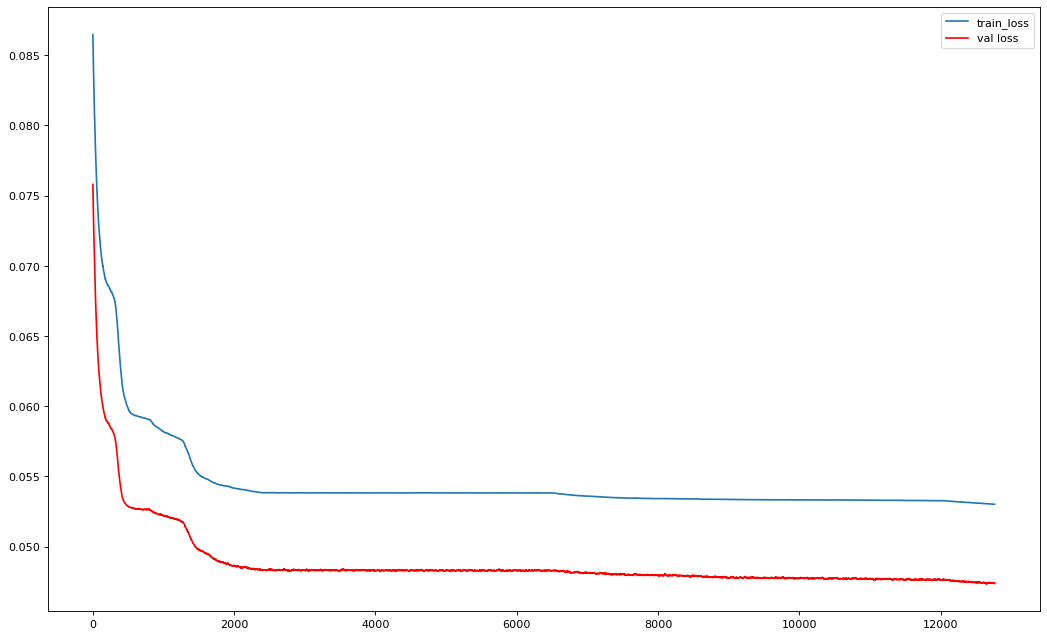

In [38]:
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, c='red', label='val loss')
plt.legend()

# Setting optimized static locations

In [39]:
def set_static():

    for ambulance in range(6):
    
        sub['A'+str(ambulance)+'_Latitude'] = amb_locs[ambulance].detach().numpy()[0]
    
        sub['A'+str(ambulance)+'_Longitude'] = amb_locs[ambulance].detach().numpy()[1]

In [40]:
years = df['year']

In [41]:
set_static()

**Distance Baseline score on test set for all 2019 accidents using static ambulance locations**

In [42]:
#Distance Baseline score on test set for all 2019 accidents using static ambulance locations

score(sub, reference)

91.07854770659885

In [43]:
sub.to_csv('baseline_static.csv')

# Moving static locations in response to external factors with Gradient Descent (Conditions Groupings) 

Using the ambulance locations determined on the general datatset, can we move the ambulance postions in response to surrounding group factors. e.g dayofweek, 3h, weather conditions.

In [44]:
#Initial static ambulance locations

amb_locs

tensor([[-1.4736, 37.0255],
        [-1.2861, 36.8220],
        [-1.2193, 36.8917],
        [-1.1142, 37.0089],
        [-1.2628, 36.7400],
        [-1.3289, 36.8804]], requires_grad=True)

# Helper Functions for setting new ambulance locations per groupings:

In [45]:
#Function for setting new optimized static locations with single condition

def set_ambulance_single(train_locs, val_locs, learn_rate, epochs, amb_locs, cat, condition):
    
    amb_locs_t, _, _ = training_routine(train_locs, val_locs, learn_rate, epochs, amb_locs, shuffle_type = False)
    
    for ambulance in range(6):
        
        sub.loc[sub[cat] == condition, ['A'+str(ambulance)+'_Latitude']] = \
        amb_locs_t[ambulance].detach().numpy()[0]
    
        sub.loc[sub[cat] == condition, ['A'+str(ambulance)+'_Longitude']] = \
        amb_locs_t[ambulance].detach().numpy()[1]

In [46]:
#Function for setting new optimized static locations with double condition

def set_ambulance_double(train_locs, val_locs, learn_rate, epochs, amb_locs, cat, condition, cat2, condition2):
    
    amb_locs_t, _, _ = training_routine(train_locs, val_locs, learn_rate, epochs, amb_locs, shuffle_type = False)
    
    for ambulance in range(6):
        
        sub.loc[((sub[cat] == condition) & (sub[cat2] == condition2)), ['A'+str(ambulance)+'_Latitude']] = \
        amb_locs_t[ambulance].detach().numpy()[0]
    
        sub.loc[((sub[cat] == condition) & (sub[cat2] == condition2)), ['A'+str(ambulance)+'_Longitude']] = \
        amb_locs_t[ambulance].detach().numpy()[1]
        


        

        

In [47]:
#Function for setting new optimized static locations with triple condition

def set_ambulance_triple(train_locs, val_locs, learn_rate, epochs, amb_locs, cat, condition, \
                         cat2, condition2, cat3, condition3):
    
    amb_locs_t, _, _ = training_routine(train_locs, val_locs, learn_rate, epochs, amb_locs, shuffle_type = False)
    
    for ambulance in range(6):
        
        sub.loc[((sub[cat] == condition) & (sub[cat2] == condition2) & (sub[cat3] == condition3)), \
        ['A'+str(ambulance)+'_Latitude']] = amb_locs_t[ambulance].detach().numpy()[0]
    
        sub.loc[((sub[cat] == condition) & (sub[cat2] == condition2) &  (sub[cat3] == condition3)), \
        ['A'+str(ambulance)+'_Longitude']] = amb_locs_t[ambulance].detach().numpy()[1]

#### Cross Validation:- From analysis, certain days and times are worth setting separate locations but we need to cross-validate these days and not overfit to non-generalizable conditions. We adopt a two step validation approach of first using repeated cross-validation to find days possibly worth setting seperate locations, settings which improve beyond the static baseline approach. We will next train on all data and compare the distance score improvement. We have the highest trust in conditions which improve distance score and mean cross val score and check performance on the LB. Mild trust in conditions which only improve distance score using all the data.

### Setting different locations for conditions

#### Single Condition Settings: Day of Week (Using as initial condition to move ambulance and identify days of week worth setting separate locations)

##### Cross-Validation Routine for Single Category - Dayofweek/Day-zone

Static Distance - 90.78796

Static Cross-Val mean - 18.17185896606233

Observation- Based on cross-validation results and distance validation results, certain days of the week are better individually tuned. Significant boost in validation performance compared to other days of the week.

Selected Days of Week from tuning- 0 & 6 show the largest boost from cross-validation and LB performance. 3, 4, 5 show small improvement when tuned individually.

Try binning the 3,4,5 days of relatively high accidents, mid-peaks.

Try binning other daysofweek & check cross-validation performance

In [48]:
def create_week_categories(df):
    
    if df in ([1, 2]):
        
        return 'peak-days'
    
    if df in ([3, 4, 5]):
        
        return 'mid-peaks'
    
    else:
        
        return 'none'
    
    

In [49]:
df['day-zone'] = df['dayofweek'].apply(create_week_categories)

sub['day-zone'] = sub['dayofweek'].apply(create_week_categories)

Cross-Val score of Mid-peaks is better than individual days 3, 4, 5. Minor boost using Mid-peaks to represent mid-accident activity days even on LB.
Mid-peak improves overall score when fine-tuned on entire data. Overall performance improvement setting different times for the mid-peak days.

 ##### Validation Routine on full dataset for Selected Days of Week:

In [50]:
sub.to_csv('exp.csv')

In [51]:
#Setting optimized static locations and dayofweek new best one

def set_static_week():
    
    set_static()

    elements = [(0, 0.009, 400, 'dayofweek'), (6, 0.009, 450, 'dayofweek'), ('mid-peaks', 0.0001, 150, 'day-zone')]


    for element in elements:
    
    
        day, lr, epoch, category = element[0], element[1], element[2], element[3]


        train_cat = extract_data(df, category,  [day], 'dynamic', 'single')
    
        val_cat = extract_data(df, category, [day], 'val', 'single')

        amb_locs_new = amb_locs.clone().detach()
    
    
    
        set_ambulance_single(train_cat, val_cat,  lr, epoch, amb_locs_new, category, day)
    
        print(score(sub, reference))
        
    return sub
        
    
        
    

### Selected Days of Week and Time-zone combination Tuning:

##### Cross-Validation routine for selected dayofweek & time-zone period (Hyper-parameter tuning)

In [52]:
set_static_week()

Epoch : 0... Train loss: 0.056852... Val loss : 0.056426...
Epoch : 1... Train loss: 0.056765... Val loss : 0.056260...
Epoch : 2... Train loss: 0.056707... Val loss : 0.056098...
Epoch : 3... Train loss: 0.056676... Val loss : 0.056030...
Epoch : 4... Train loss: 0.056652... Val loss : 0.055984...
Epoch : 5... Train loss: 0.056631... Val loss : 0.055942...
Epoch : 6... Train loss: 0.056615... Val loss : 0.055907...
Epoch : 7... Train loss: 0.056601... Val loss : 0.055879...
Epoch : 8... Train loss: 0.056590... Val loss : 0.055855...
Epoch : 9... Train loss: 0.056579... Val loss : 0.055836...
Epoch : 10... Train loss: 0.056569... Val loss : 0.055820...
Epoch : 11... Train loss: 0.056561... Val loss : 0.055806...
Epoch : 12... Train loss: 0.056553... Val loss : 0.055795...
Epoch : 13... Train loss: 0.056545... Val loss : 0.055785...
Epoch : 14... Train loss: 0.056538... Val loss : 0.055777...
Epoch : 15... Train loss: 0.056532... Val loss : 0.055770...
Epoch : 16... Train loss: 0.056523

Epoch : 137... Train loss: 0.055696... Val loss : 0.055414...
Epoch : 138... Train loss: 0.055696... Val loss : 0.055414...
Epoch : 139... Train loss: 0.055696... Val loss : 0.055413...
Epoch : 140... Train loss: 0.055696... Val loss : 0.055413...
Epoch : 141... Train loss: 0.055696... Val loss : 0.055412...
Epoch : 142... Train loss: 0.055696... Val loss : 0.055411...
Epoch : 143... Train loss: 0.055696... Val loss : 0.055411...
Epoch : 144... Train loss: 0.055696... Val loss : 0.055410...
Epoch : 145... Train loss: 0.055696... Val loss : 0.055410...
Epoch : 146... Train loss: 0.055696... Val loss : 0.055409...
Epoch : 147... Train loss: 0.055696... Val loss : 0.055409...
Epoch : 148... Train loss: 0.055696... Val loss : 0.055408...
Epoch : 149... Train loss: 0.055696... Val loss : 0.055408...
Epoch : 150... Train loss: 0.055696... Val loss : 0.055408...
Epoch : 151... Train loss: 0.055696... Val loss : 0.055407...
Epoch : 152... Train loss: 0.055696... Val loss : 0.055407...
Epoch : 

Epoch : 273... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 274... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 275... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 276... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 277... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 278... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 279... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 280... Train loss: 0.055696... Val loss : 0.055386...
Epoch : 281... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 282... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 283... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 284... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 285... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 286... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 287... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 288... Train loss: 0.055696... Val loss : 0.055385...
Epoch : 

Epoch : 11... Train loss: 0.054677... Val loss : 0.054897...
Epoch : 12... Train loss: 0.054639... Val loss : 0.054800...
Epoch : 13... Train loss: 0.054611... Val loss : 0.054762...
Epoch : 14... Train loss: 0.054586... Val loss : 0.054728...
Epoch : 15... Train loss: 0.054563... Val loss : 0.054696...
Epoch : 16... Train loss: 0.054540... Val loss : 0.054664...
Epoch : 17... Train loss: 0.054518... Val loss : 0.054633...
Epoch : 18... Train loss: 0.054497... Val loss : 0.054601...
Epoch : 19... Train loss: 0.054475... Val loss : 0.054577...
Epoch : 20... Train loss: 0.054451... Val loss : 0.054539...
Epoch : 21... Train loss: 0.054428... Val loss : 0.054501...
Epoch : 22... Train loss: 0.054406... Val loss : 0.054464...
Epoch : 23... Train loss: 0.054384... Val loss : 0.054428...
Epoch : 24... Train loss: 0.054354... Val loss : 0.054393...
Epoch : 25... Train loss: 0.054294... Val loss : 0.054282...
Epoch : 26... Train loss: 0.054238... Val loss : 0.054173...
Epoch : 27... Train loss

Epoch : 145... Train loss: 0.053474... Val loss : 0.051782...
Epoch : 146... Train loss: 0.053474... Val loss : 0.051780...
Epoch : 147... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 148... Train loss: 0.053474... Val loss : 0.051777...
Epoch : 149... Train loss: 0.053473... Val loss : 0.051783...
Epoch : 150... Train loss: 0.053474... Val loss : 0.051780...
Epoch : 151... Train loss: 0.053474... Val loss : 0.051784...
Epoch : 152... Train loss: 0.053475... Val loss : 0.051777...
Epoch : 153... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 154... Train loss: 0.053474... Val loss : 0.051780...
Epoch : 155... Train loss: 0.053474... Val loss : 0.051784...
Epoch : 156... Train loss: 0.053475... Val loss : 0.051777...
Epoch : 157... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 158... Train loss: 0.053474... Val loss : 0.051780...
Epoch : 159... Train loss: 0.053474... Val loss : 0.051783...
Epoch : 160... Train loss: 0.053475... Val loss : 0.051777...
Epoch : 

Epoch : 281... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 282... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 283... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 284... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 285... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 286... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 287... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 288... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 289... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 290... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 291... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 292... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 293... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 294... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 295... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 296... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 

Epoch : 419... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 420... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 421... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 422... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 423... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 424... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 425... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 426... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 427... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 428... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 429... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 430... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 431... Train loss: 0.053473... Val loss : 0.051784...
Epoch : 432... Train loss: 0.053474... Val loss : 0.051778...
Epoch : 433... Train loss: 0.053473... Val loss : 0.051785...
Epoch : 434... Train loss: 0.053474... Val loss : 0.051779...
Epoch : 

Epoch : 104... Train loss: 0.049483... Val loss : 0.048050...
Epoch : 105... Train loss: 0.049482... Val loss : 0.048049...
Epoch : 106... Train loss: 0.049481... Val loss : 0.048048...
Epoch : 107... Train loss: 0.049480... Val loss : 0.048047...
Epoch : 108... Train loss: 0.049479... Val loss : 0.048046...
Epoch : 109... Train loss: 0.049478... Val loss : 0.048045...
Epoch : 110... Train loss: 0.049477... Val loss : 0.048044...
Epoch : 111... Train loss: 0.049476... Val loss : 0.048043...
Epoch : 112... Train loss: 0.049476... Val loss : 0.048042...
Epoch : 113... Train loss: 0.049475... Val loss : 0.048041...
Epoch : 114... Train loss: 0.049474... Val loss : 0.048040...
Epoch : 115... Train loss: 0.049473... Val loss : 0.048039...
Epoch : 116... Train loss: 0.049472... Val loss : 0.048038...
Epoch : 117... Train loss: 0.049471... Val loss : 0.048037...
Epoch : 118... Train loss: 0.049470... Val loss : 0.048036...
Epoch : 119... Train loss: 0.049469... Val loss : 0.048035...
Epoch : 

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,...,specific_humidity_2m_above_ground-bin,temperature_2m_above_ground-bin,u_component_of_wind_10m_above_ground-bin,v_component_of_wind_10m_above_ground-bin,3h,year,weekend/week,dayofweek,month,day-zone
0,2019-01-01 00:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,low,mid,low,0,2019,0.0,1,1,peak-days
1,2019-01-01 03:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,low,mid,low,3,2019,0.0,1,1,peak-days
2,2019-01-01 06:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,low,mid,low,6,2019,0.0,1,1,peak-days
3,2019-01-01 09:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,low,mid,low,9,2019,0.0,1,1,peak-days
4,2019-01-01 12:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,low,mid,low,12,2019,0.0,1,1,peak-days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2019-12-31 12:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,mid,mid,low,12,2019,0.0,1,12,peak-days
2917,2019-12-31 15:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,mid,mid,low,15,2019,0.0,1,12,peak-days
2918,2019-12-31 18:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,mid,mid,low,18,2019,0.0,1,12,peak-days
2919,2019-12-31 21:00:00,-1.473561,37.025528,-1.286123,36.821987,-1.219275,36.891716,-1.114229,37.008926,-1.262773,...,mid,mid,mid,low,21,2019,0.0,1,12,peak-days


In [53]:
def create_time_categories(df):
    
    if df in ([0, 3, 21]):
        
        return 'off-time'
    
    if df in ([6, 9]):
        
        return 'peak-time'
    
    else:
        
        return 'mid-time'
    
    

In [54]:
df['time-zone'] = df['3h'].apply(create_time_categories)

sub['time-zone'] = sub['3h'].apply(create_time_categories)


In [55]:
#Train with best LB one

elements = [(0, 'peak-time', 0.00004, 500), (0, 'mid-time', 0.002, 500), ('peak-days', 'peak-time', 0.007, 700), \
            (1, 'mid-time', 0.00004, 600), ('mid-peaks', 'mid-time', 0.00004, 500), (3, 'peak-time', 0.00015, 500),
            (5, 'mid-time', 0.008, 500)]

for element in elements:
    
    day, time, lr, epoch = element[0], element[1], element[2], element[3]
    
    print(day, time)
    
    if day in list(df['day-zone'].unique()):
        
        day_ver = 'day-zone'
        
    else:
        
        day_ver = 'dayofweek'


    train_cat = extract_data(df, 'time-zone',  time, 'dynamic', 'double', \
                                     day_ver, day)
    
    val_cat = extract_data(df, 'time-zone', time, 'val', 'double', \
                                   day_ver, day)
        
    amb_locs_new = amb_locs.clone().detach()
    
    
    set_ambulance_double(train_cat, val_cat, lr, epoch, amb_locs_new, \
                                 'time-zone', time, day_ver, day)
        
        
        
    print('present score {}'.format(score(sub, reference)))
        

0 peak-time
Epoch : 0... Train loss: 0.050495... Val loss : 0.053010...
Epoch : 1... Train loss: 0.050493... Val loss : 0.053008...
Epoch : 2... Train loss: 0.050490... Val loss : 0.053005...
Epoch : 3... Train loss: 0.050488... Val loss : 0.053002...
Epoch : 4... Train loss: 0.050486... Val loss : 0.053000...
Epoch : 5... Train loss: 0.050483... Val loss : 0.052997...
Epoch : 6... Train loss: 0.050481... Val loss : 0.052995...
Epoch : 7... Train loss: 0.050479... Val loss : 0.052992...
Epoch : 8... Train loss: 0.050476... Val loss : 0.052990...
Epoch : 9... Train loss: 0.050474... Val loss : 0.052987...
Epoch : 10... Train loss: 0.050472... Val loss : 0.052985...
Epoch : 11... Train loss: 0.050470... Val loss : 0.052982...
Epoch : 12... Train loss: 0.050467... Val loss : 0.052980...
Epoch : 13... Train loss: 0.050465... Val loss : 0.052978...
Epoch : 14... Train loss: 0.050463... Val loss : 0.052975...
Epoch : 15... Train loss: 0.050461... Val loss : 0.052973...
Epoch : 16... Train lo

Epoch : 137... Train loss: 0.050277... Val loss : 0.052744...
Epoch : 138... Train loss: 0.050276... Val loss : 0.052742...
Epoch : 139... Train loss: 0.050275... Val loss : 0.052741...
Epoch : 140... Train loss: 0.050274... Val loss : 0.052739...
Epoch : 141... Train loss: 0.050273... Val loss : 0.052737...
Epoch : 142... Train loss: 0.050272... Val loss : 0.052736...
Epoch : 143... Train loss: 0.050271... Val loss : 0.052734...
Epoch : 144... Train loss: 0.050270... Val loss : 0.052733...
Epoch : 145... Train loss: 0.050269... Val loss : 0.052731...
Epoch : 146... Train loss: 0.050268... Val loss : 0.052730...
Epoch : 147... Train loss: 0.050267... Val loss : 0.052728...
Epoch : 148... Train loss: 0.050266... Val loss : 0.052727...
Epoch : 149... Train loss: 0.050265... Val loss : 0.052725...
Epoch : 150... Train loss: 0.050264... Val loss : 0.052724...
Epoch : 151... Train loss: 0.050262... Val loss : 0.052722...
Epoch : 152... Train loss: 0.050261... Val loss : 0.052721...
Epoch : 

Epoch : 270... Train loss: 0.050176... Val loss : 0.052575...
Epoch : 271... Train loss: 0.050176... Val loss : 0.052574...
Epoch : 272... Train loss: 0.050175... Val loss : 0.052573...
Epoch : 273... Train loss: 0.050175... Val loss : 0.052572...
Epoch : 274... Train loss: 0.050174... Val loss : 0.052571...
Epoch : 275... Train loss: 0.050173... Val loss : 0.052570...
Epoch : 276... Train loss: 0.050173... Val loss : 0.052569...
Epoch : 277... Train loss: 0.050172... Val loss : 0.052567...
Epoch : 278... Train loss: 0.050171... Val loss : 0.052566...
Epoch : 279... Train loss: 0.050171... Val loss : 0.052565...
Epoch : 280... Train loss: 0.050170... Val loss : 0.052564...
Epoch : 281... Train loss: 0.050170... Val loss : 0.052563...
Epoch : 282... Train loss: 0.050169... Val loss : 0.052562...
Epoch : 283... Train loss: 0.050168... Val loss : 0.052561...
Epoch : 284... Train loss: 0.050168... Val loss : 0.052560...
Epoch : 285... Train loss: 0.050167... Val loss : 0.052559...
Epoch : 

Epoch : 404... Train loss: 0.050100... Val loss : 0.052442...
Epoch : 405... Train loss: 0.050100... Val loss : 0.052441...
Epoch : 406... Train loss: 0.050099... Val loss : 0.052440...
Epoch : 407... Train loss: 0.050098... Val loss : 0.052439...
Epoch : 408... Train loss: 0.050098... Val loss : 0.052437...
Epoch : 409... Train loss: 0.050097... Val loss : 0.052436...
Epoch : 410... Train loss: 0.050096... Val loss : 0.052435...
Epoch : 411... Train loss: 0.050096... Val loss : 0.052434...
Epoch : 412... Train loss: 0.050095... Val loss : 0.052432...
Epoch : 413... Train loss: 0.050094... Val loss : 0.052431...
Epoch : 414... Train loss: 0.050094... Val loss : 0.052430...
Epoch : 415... Train loss: 0.050093... Val loss : 0.052428...
Epoch : 416... Train loss: 0.050092... Val loss : 0.052427...
Epoch : 417... Train loss: 0.050092... Val loss : 0.052426...
Epoch : 418... Train loss: 0.050091... Val loss : 0.052424...
Epoch : 419... Train loss: 0.050090... Val loss : 0.052423...
Epoch : 

Epoch : 42... Train loss: 0.070143... Val loss : 0.066544...
Epoch : 43... Train loss: 0.070124... Val loss : 0.066540...
Epoch : 44... Train loss: 0.070100... Val loss : 0.066531...
Epoch : 45... Train loss: 0.070076... Val loss : 0.066522...
Epoch : 46... Train loss: 0.070049... Val loss : 0.066514...
Epoch : 47... Train loss: 0.070019... Val loss : 0.066505...
Epoch : 48... Train loss: 0.069990... Val loss : 0.066497...
Epoch : 49... Train loss: 0.069962... Val loss : 0.066489...
Epoch : 50... Train loss: 0.069929... Val loss : 0.066483...
Epoch : 51... Train loss: 0.069896... Val loss : 0.066478...
Epoch : 52... Train loss: 0.069862... Val loss : 0.066472...
Epoch : 53... Train loss: 0.069820... Val loss : 0.066460...
Epoch : 54... Train loss: 0.069774... Val loss : 0.066448...
Epoch : 55... Train loss: 0.069723... Val loss : 0.066432...
Epoch : 56... Train loss: 0.069673... Val loss : 0.066416...
Epoch : 57... Train loss: 0.069625... Val loss : 0.066400...
Epoch : 58... Train loss

Epoch : 177... Train loss: 0.067759... Val loss : 0.065385...
Epoch : 178... Train loss: 0.067754... Val loss : 0.065386...
Epoch : 179... Train loss: 0.067749... Val loss : 0.065386...
Epoch : 180... Train loss: 0.067744... Val loss : 0.065386...
Epoch : 181... Train loss: 0.067740... Val loss : 0.065387...
Epoch : 182... Train loss: 0.067735... Val loss : 0.065388...
Epoch : 183... Train loss: 0.067730... Val loss : 0.065388...
Epoch : 184... Train loss: 0.067725... Val loss : 0.065389...
Epoch : 185... Train loss: 0.067721... Val loss : 0.065389...
Epoch : 186... Train loss: 0.067716... Val loss : 0.065390...
Epoch : 187... Train loss: 0.067711... Val loss : 0.065391...
Epoch : 188... Train loss: 0.067707... Val loss : 0.065392...
Epoch : 189... Train loss: 0.067702... Val loss : 0.065392...
Epoch : 190... Train loss: 0.067698... Val loss : 0.065393...
Epoch : 191... Train loss: 0.067693... Val loss : 0.065394...
Epoch : 192... Train loss: 0.067689... Val loss : 0.065395...
Epoch : 

Epoch : 311... Train loss: 0.066669... Val loss : 0.064803...
Epoch : 312... Train loss: 0.066660... Val loss : 0.064798...
Epoch : 313... Train loss: 0.066650... Val loss : 0.064792...
Epoch : 314... Train loss: 0.066641... Val loss : 0.064787...
Epoch : 315... Train loss: 0.066632... Val loss : 0.064782...
Epoch : 316... Train loss: 0.066624... Val loss : 0.064777...
Epoch : 317... Train loss: 0.066615... Val loss : 0.064772...
Epoch : 318... Train loss: 0.066606... Val loss : 0.064768...
Epoch : 319... Train loss: 0.066598... Val loss : 0.064763...
Epoch : 320... Train loss: 0.066590... Val loss : 0.064759...
Epoch : 321... Train loss: 0.066581... Val loss : 0.064755...
Epoch : 322... Train loss: 0.066573... Val loss : 0.064751...
Epoch : 323... Train loss: 0.066565... Val loss : 0.064747...
Epoch : 324... Train loss: 0.066557... Val loss : 0.064743...
Epoch : 325... Train loss: 0.066549... Val loss : 0.064739...
Epoch : 326... Train loss: 0.066541... Val loss : 0.064735...
Epoch : 

Epoch : 449... Train loss: 0.065810... Val loss : 0.064199...
Epoch : 450... Train loss: 0.065805... Val loss : 0.064193...
Epoch : 451... Train loss: 0.065799... Val loss : 0.064187...
Epoch : 452... Train loss: 0.065793... Val loss : 0.064181...
Epoch : 453... Train loss: 0.065788... Val loss : 0.064174...
Epoch : 454... Train loss: 0.065782... Val loss : 0.064168...
Epoch : 455... Train loss: 0.065777... Val loss : 0.064162...
Epoch : 456... Train loss: 0.065771... Val loss : 0.064156...
Epoch : 457... Train loss: 0.065766... Val loss : 0.064151...
Epoch : 458... Train loss: 0.065760... Val loss : 0.064145...
Epoch : 459... Train loss: 0.065755... Val loss : 0.064139...
Epoch : 460... Train loss: 0.065749... Val loss : 0.064134...
Epoch : 461... Train loss: 0.065744... Val loss : 0.064128...
Epoch : 462... Train loss: 0.065739... Val loss : 0.064123...
Epoch : 463... Train loss: 0.065733... Val loss : 0.064118...
Epoch : 464... Train loss: 0.065728... Val loss : 0.064113...
Epoch : 

Epoch : 83... Train loss: 0.050236... Val loss : 0.039616...
Epoch : 84... Train loss: 0.050236... Val loss : 0.039615...
Epoch : 85... Train loss: 0.050236... Val loss : 0.039614...
Epoch : 86... Train loss: 0.050236... Val loss : 0.039613...
Epoch : 87... Train loss: 0.050236... Val loss : 0.039613...
Epoch : 88... Train loss: 0.050236... Val loss : 0.039612...
Epoch : 89... Train loss: 0.050236... Val loss : 0.039612...
Epoch : 90... Train loss: 0.050236... Val loss : 0.039611...
Epoch : 91... Train loss: 0.050236... Val loss : 0.039610...
Epoch : 92... Train loss: 0.050236... Val loss : 0.039610...
Epoch : 93... Train loss: 0.050236... Val loss : 0.039609...
Epoch : 94... Train loss: 0.050235... Val loss : 0.039609...
Epoch : 95... Train loss: 0.050235... Val loss : 0.039608...
Epoch : 96... Train loss: 0.050235... Val loss : 0.039608...
Epoch : 97... Train loss: 0.050235... Val loss : 0.039607...
Epoch : 98... Train loss: 0.050235... Val loss : 0.039607...
Epoch : 99... Train loss

Epoch : 219... Train loss: 0.050232... Val loss : 0.039580...
Epoch : 220... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 221... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 222... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 223... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 224... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 225... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 226... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 227... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 228... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 229... Train loss: 0.050232... Val loss : 0.039579...
Epoch : 230... Train loss: 0.050232... Val loss : 0.039578...
Epoch : 231... Train loss: 0.050232... Val loss : 0.039578...
Epoch : 232... Train loss: 0.050232... Val loss : 0.039578...
Epoch : 233... Train loss: 0.050232... Val loss : 0.039578...
Epoch : 234... Train loss: 0.050232... Val loss : 0.039578...
Epoch : 

Epoch : 354... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 355... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 356... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 357... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 358... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 359... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 360... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 361... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 362... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 363... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 364... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 365... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 366... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 367... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 368... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 369... Train loss: 0.050230... Val loss : 0.039573...
Epoch : 

Epoch : 490... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 491... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 492... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 493... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 494... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 495... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 496... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 497... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 498... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 499... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 500... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 501... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 502... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 503... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 504... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 505... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 

Epoch : 623... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 624... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 625... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 626... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 627... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 628... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 629... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 630... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 631... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 632... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 633... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 634... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 635... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 636... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 637... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 638... Train loss: 0.050229... Val loss : 0.039571...
Epoch : 

Epoch : 59... Train loss: 0.045061... Val loss : 0.040508...
Epoch : 60... Train loss: 0.045057... Val loss : 0.040510...
Epoch : 61... Train loss: 0.045053... Val loss : 0.040512...
Epoch : 62... Train loss: 0.045049... Val loss : 0.040513...
Epoch : 63... Train loss: 0.045045... Val loss : 0.040515...
Epoch : 64... Train loss: 0.045041... Val loss : 0.040517...
Epoch : 65... Train loss: 0.045037... Val loss : 0.040518...
Epoch : 66... Train loss: 0.045033... Val loss : 0.040520...
Epoch : 67... Train loss: 0.045029... Val loss : 0.040522...
Epoch : 68... Train loss: 0.045025... Val loss : 0.040523...
Epoch : 69... Train loss: 0.045021... Val loss : 0.040525...
Epoch : 70... Train loss: 0.045017... Val loss : 0.040527...
Epoch : 71... Train loss: 0.045013... Val loss : 0.040529...
Epoch : 72... Train loss: 0.045010... Val loss : 0.040531...
Epoch : 73... Train loss: 0.045006... Val loss : 0.040532...
Epoch : 74... Train loss: 0.045002... Val loss : 0.040534...
Epoch : 75... Train loss

Epoch : 198... Train loss: 0.044556... Val loss : 0.040818...
Epoch : 199... Train loss: 0.044553... Val loss : 0.040820...
Epoch : 200... Train loss: 0.044550... Val loss : 0.040823...
Epoch : 201... Train loss: 0.044547... Val loss : 0.040825...
Epoch : 202... Train loss: 0.044544... Val loss : 0.040827...
Epoch : 203... Train loss: 0.044541... Val loss : 0.040829...
Epoch : 204... Train loss: 0.044538... Val loss : 0.040832...
Epoch : 205... Train loss: 0.044535... Val loss : 0.040834...
Epoch : 206... Train loss: 0.044532... Val loss : 0.040836...
Epoch : 207... Train loss: 0.044529... Val loss : 0.040838...
Epoch : 208... Train loss: 0.044526... Val loss : 0.040841...
Epoch : 209... Train loss: 0.044523... Val loss : 0.040843...
Epoch : 210... Train loss: 0.044520... Val loss : 0.040845...
Epoch : 211... Train loss: 0.044517... Val loss : 0.040848...
Epoch : 212... Train loss: 0.044514... Val loss : 0.040850...
Epoch : 213... Train loss: 0.044511... Val loss : 0.040852...
Epoch : 

Epoch : 334... Train loss: 0.044264... Val loss : 0.041087...
Epoch : 335... Train loss: 0.044263... Val loss : 0.041089...
Epoch : 336... Train loss: 0.044262... Val loss : 0.041090...
Epoch : 337... Train loss: 0.044261... Val loss : 0.041091...
Epoch : 338... Train loss: 0.044260... Val loss : 0.041092...
Epoch : 339... Train loss: 0.044259... Val loss : 0.041093...
Epoch : 340... Train loss: 0.044259... Val loss : 0.041095...
Epoch : 341... Train loss: 0.044258... Val loss : 0.041096...
Epoch : 342... Train loss: 0.044257... Val loss : 0.041097...
Epoch : 343... Train loss: 0.044256... Val loss : 0.041098...
Epoch : 344... Train loss: 0.044255... Val loss : 0.041100...
Epoch : 345... Train loss: 0.044254... Val loss : 0.041101...
Epoch : 346... Train loss: 0.044253... Val loss : 0.041102...
Epoch : 347... Train loss: 0.044253... Val loss : 0.041103...
Epoch : 348... Train loss: 0.044252... Val loss : 0.041105...
Epoch : 349... Train loss: 0.044251... Val loss : 0.041106...
Epoch : 

Epoch : 470... Train loss: 0.044169... Val loss : 0.041236...
Epoch : 471... Train loss: 0.044168... Val loss : 0.041237...
Epoch : 472... Train loss: 0.044168... Val loss : 0.041238...
Epoch : 473... Train loss: 0.044167... Val loss : 0.041239...
Epoch : 474... Train loss: 0.044167... Val loss : 0.041240...
Epoch : 475... Train loss: 0.044166... Val loss : 0.041241...
Epoch : 476... Train loss: 0.044166... Val loss : 0.041242...
Epoch : 477... Train loss: 0.044165... Val loss : 0.041244...
Epoch : 478... Train loss: 0.044164... Val loss : 0.041245...
Epoch : 479... Train loss: 0.044164... Val loss : 0.041246...
Epoch : 480... Train loss: 0.044163... Val loss : 0.041247...
Epoch : 481... Train loss: 0.044163... Val loss : 0.041248...
Epoch : 482... Train loss: 0.044162... Val loss : 0.041249...
Epoch : 483... Train loss: 0.044161... Val loss : 0.041250...
Epoch : 484... Train loss: 0.044161... Val loss : 0.041251...
Epoch : 485... Train loss: 0.044160... Val loss : 0.041252...
Epoch : 

Epoch : 2... Train loss: 0.053412... Val loss : 0.046875...
Epoch : 3... Train loss: 0.053410... Val loss : 0.046873...
Epoch : 4... Train loss: 0.053408... Val loss : 0.046871...
Epoch : 5... Train loss: 0.053406... Val loss : 0.046868...
Epoch : 6... Train loss: 0.053404... Val loss : 0.046866...
Epoch : 7... Train loss: 0.053402... Val loss : 0.046864...
Epoch : 8... Train loss: 0.053401... Val loss : 0.046863...
Epoch : 9... Train loss: 0.053399... Val loss : 0.046861...
Epoch : 10... Train loss: 0.053398... Val loss : 0.046859...
Epoch : 11... Train loss: 0.053397... Val loss : 0.046857...
Epoch : 12... Train loss: 0.053396... Val loss : 0.046856...
Epoch : 13... Train loss: 0.053395... Val loss : 0.046854...
Epoch : 14... Train loss: 0.053394... Val loss : 0.046853...
Epoch : 15... Train loss: 0.053393... Val loss : 0.046851...
Epoch : 16... Train loss: 0.053392... Val loss : 0.046850...
Epoch : 17... Train loss: 0.053391... Val loss : 0.046848...
Epoch : 18... Train loss: 0.0533

Epoch : 137... Train loss: 0.053330... Val loss : 0.046750...
Epoch : 138... Train loss: 0.053330... Val loss : 0.046749...
Epoch : 139... Train loss: 0.053329... Val loss : 0.046749...
Epoch : 140... Train loss: 0.053329... Val loss : 0.046748...
Epoch : 141... Train loss: 0.053329... Val loss : 0.046748...
Epoch : 142... Train loss: 0.053329... Val loss : 0.046747...
Epoch : 143... Train loss: 0.053328... Val loss : 0.046747...
Epoch : 144... Train loss: 0.053328... Val loss : 0.046746...
Epoch : 145... Train loss: 0.053328... Val loss : 0.046746...
Epoch : 146... Train loss: 0.053327... Val loss : 0.046746...
Epoch : 147... Train loss: 0.053327... Val loss : 0.046745...
Epoch : 148... Train loss: 0.053327... Val loss : 0.046745...
Epoch : 149... Train loss: 0.053327... Val loss : 0.046744...
Epoch : 150... Train loss: 0.053326... Val loss : 0.046744...
Epoch : 151... Train loss: 0.053326... Val loss : 0.046743...
Epoch : 152... Train loss: 0.053326... Val loss : 0.046743...
Epoch : 

Epoch : 272... Train loss: 0.053299... Val loss : 0.046719...
Epoch : 273... Train loss: 0.053299... Val loss : 0.046719...
Epoch : 274... Train loss: 0.053298... Val loss : 0.046719...
Epoch : 275... Train loss: 0.053298... Val loss : 0.046719...
Epoch : 276... Train loss: 0.053298... Val loss : 0.046719...
Epoch : 277... Train loss: 0.053298... Val loss : 0.046719...
Epoch : 278... Train loss: 0.053298... Val loss : 0.046718...
Epoch : 279... Train loss: 0.053297... Val loss : 0.046718...
Epoch : 280... Train loss: 0.053297... Val loss : 0.046718...
Epoch : 281... Train loss: 0.053297... Val loss : 0.046718...
Epoch : 282... Train loss: 0.053297... Val loss : 0.046718...
Epoch : 283... Train loss: 0.053297... Val loss : 0.046718...
Epoch : 284... Train loss: 0.053296... Val loss : 0.046718...
Epoch : 285... Train loss: 0.053296... Val loss : 0.046718...
Epoch : 286... Train loss: 0.053296... Val loss : 0.046718...
Epoch : 287... Train loss: 0.053296... Val loss : 0.046718...
Epoch : 

Epoch : 405... Train loss: 0.053274... Val loss : 0.046715...
Epoch : 406... Train loss: 0.053274... Val loss : 0.046715...
Epoch : 407... Train loss: 0.053274... Val loss : 0.046715...
Epoch : 408... Train loss: 0.053274... Val loss : 0.046715...
Epoch : 409... Train loss: 0.053274... Val loss : 0.046715...
Epoch : 410... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 411... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 412... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 413... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 414... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 415... Train loss: 0.053273... Val loss : 0.046715...
Epoch : 416... Train loss: 0.053272... Val loss : 0.046715...
Epoch : 417... Train loss: 0.053272... Val loss : 0.046715...
Epoch : 418... Train loss: 0.053272... Val loss : 0.046715...
Epoch : 419... Train loss: 0.053272... Val loss : 0.046715...
Epoch : 420... Train loss: 0.053272... Val loss : 0.046715...
Epoch : 

Epoch : 47... Train loss: 0.049744... Val loss : 0.052900...
Epoch : 48... Train loss: 0.049737... Val loss : 0.052890...
Epoch : 49... Train loss: 0.049730... Val loss : 0.052880...
Epoch : 50... Train loss: 0.049722... Val loss : 0.052871...
Epoch : 51... Train loss: 0.049715... Val loss : 0.052861...
Epoch : 52... Train loss: 0.049708... Val loss : 0.052851...
Epoch : 53... Train loss: 0.049701... Val loss : 0.052841...
Epoch : 54... Train loss: 0.049694... Val loss : 0.052832...
Epoch : 55... Train loss: 0.049687... Val loss : 0.052822...
Epoch : 56... Train loss: 0.049680... Val loss : 0.052813...
Epoch : 57... Train loss: 0.049673... Val loss : 0.052804...
Epoch : 58... Train loss: 0.049666... Val loss : 0.052795...
Epoch : 59... Train loss: 0.049659... Val loss : 0.052786...
Epoch : 60... Train loss: 0.049653... Val loss : 0.052777...
Epoch : 61... Train loss: 0.049646... Val loss : 0.052768...
Epoch : 62... Train loss: 0.049639... Val loss : 0.052759...
Epoch : 63... Train loss

Epoch : 186... Train loss: 0.048624... Val loss : 0.051479...
Epoch : 187... Train loss: 0.048617... Val loss : 0.051470...
Epoch : 188... Train loss: 0.048609... Val loss : 0.051461...
Epoch : 189... Train loss: 0.048602... Val loss : 0.051452...
Epoch : 190... Train loss: 0.048594... Val loss : 0.051443...
Epoch : 191... Train loss: 0.048587... Val loss : 0.051434...
Epoch : 192... Train loss: 0.048579... Val loss : 0.051425...
Epoch : 193... Train loss: 0.048572... Val loss : 0.051417...
Epoch : 194... Train loss: 0.048565... Val loss : 0.051408...
Epoch : 195... Train loss: 0.048557... Val loss : 0.051399...
Epoch : 196... Train loss: 0.048550... Val loss : 0.051390...
Epoch : 197... Train loss: 0.048542... Val loss : 0.051381...
Epoch : 198... Train loss: 0.048535... Val loss : 0.051372...
Epoch : 199... Train loss: 0.048528... Val loss : 0.051363...
Epoch : 200... Train loss: 0.048520... Val loss : 0.051355...
Epoch : 201... Train loss: 0.048513... Val loss : 0.051346...
Epoch : 

Epoch : 324... Train loss: 0.048152... Val loss : 0.050859...
Epoch : 325... Train loss: 0.048152... Val loss : 0.050858...
Epoch : 326... Train loss: 0.048151... Val loss : 0.050856...
Epoch : 327... Train loss: 0.048151... Val loss : 0.050854...
Epoch : 328... Train loss: 0.048150... Val loss : 0.050853...
Epoch : 329... Train loss: 0.048150... Val loss : 0.050851...
Epoch : 330... Train loss: 0.048150... Val loss : 0.050850...
Epoch : 331... Train loss: 0.048149... Val loss : 0.050848...
Epoch : 332... Train loss: 0.048149... Val loss : 0.050847...
Epoch : 333... Train loss: 0.048148... Val loss : 0.050845...
Epoch : 334... Train loss: 0.048148... Val loss : 0.050844...
Epoch : 335... Train loss: 0.048147... Val loss : 0.050842...
Epoch : 336... Train loss: 0.048147... Val loss : 0.050841...
Epoch : 337... Train loss: 0.048146... Val loss : 0.050840...
Epoch : 338... Train loss: 0.048146... Val loss : 0.050838...
Epoch : 339... Train loss: 0.048146... Val loss : 0.050837...
Epoch : 

Epoch : 463... Train loss: 0.048116... Val loss : 0.050723...
Epoch : 464... Train loss: 0.048116... Val loss : 0.050722...
Epoch : 465... Train loss: 0.048116... Val loss : 0.050722...
Epoch : 466... Train loss: 0.048116... Val loss : 0.050721...
Epoch : 467... Train loss: 0.048115... Val loss : 0.050721...
Epoch : 468... Train loss: 0.048115... Val loss : 0.050720...
Epoch : 469... Train loss: 0.048115... Val loss : 0.050720...
Epoch : 470... Train loss: 0.048115... Val loss : 0.050719...
Epoch : 471... Train loss: 0.048115... Val loss : 0.050719...
Epoch : 472... Train loss: 0.048115... Val loss : 0.050718...
Epoch : 473... Train loss: 0.048115... Val loss : 0.050718...
Epoch : 474... Train loss: 0.048115... Val loss : 0.050717...
Epoch : 475... Train loss: 0.048115... Val loss : 0.050717...
Epoch : 476... Train loss: 0.048115... Val loss : 0.050716...
Epoch : 477... Train loss: 0.048115... Val loss : 0.050716...
Epoch : 478... Train loss: 0.048115... Val loss : 0.050715...
Epoch : 

Epoch : 98... Train loss: 0.051975... Val loss : 0.044400...
Epoch : 99... Train loss: 0.051975... Val loss : 0.044403...
Epoch : 100... Train loss: 0.051977... Val loss : 0.044398...
Epoch : 101... Train loss: 0.051974... Val loss : 0.044403...
Epoch : 102... Train loss: 0.051976... Val loss : 0.044397...
Epoch : 103... Train loss: 0.051975... Val loss : 0.044401...
Epoch : 104... Train loss: 0.051976... Val loss : 0.044396...
Epoch : 105... Train loss: 0.051974... Val loss : 0.044400...
Epoch : 106... Train loss: 0.051976... Val loss : 0.044394...
Epoch : 107... Train loss: 0.051974... Val loss : 0.044400...
Epoch : 108... Train loss: 0.051975... Val loss : 0.044394...
Epoch : 109... Train loss: 0.051975... Val loss : 0.044398...
Epoch : 110... Train loss: 0.051976... Val loss : 0.044392...
Epoch : 111... Train loss: 0.051974... Val loss : 0.044398...
Epoch : 112... Train loss: 0.051976... Val loss : 0.044392...
Epoch : 113... Train loss: 0.051975... Val loss : 0.044397...
Epoch : 11

Epoch : 232... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 233... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 234... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 235... Train loss: 0.051975... Val loss : 0.044384...
Epoch : 236... Train loss: 0.051975... Val loss : 0.044379...
Epoch : 237... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 238... Train loss: 0.051976... Val loss : 0.044378...
Epoch : 239... Train loss: 0.051974... Val loss : 0.044385...
Epoch : 240... Train loss: 0.051975... Val loss : 0.044379...
Epoch : 241... Train loss: 0.051975... Val loss : 0.044383...
Epoch : 242... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 243... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 244... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 245... Train loss: 0.051975... Val loss : 0.044384...
Epoch : 246... Train loss: 0.051975... Val loss : 0.044379...
Epoch : 247... Train loss: 0.051975... Val loss : 0.044383...
Epoch : 

Epoch : 374... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 375... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 376... Train loss: 0.051976... Val loss : 0.044378...
Epoch : 377... Train loss: 0.051974... Val loss : 0.044385...
Epoch : 378... Train loss: 0.051975... Val loss : 0.044379...
Epoch : 379... Train loss: 0.051975... Val loss : 0.044383...
Epoch : 380... Train loss: 0.051976... Val loss : 0.044378...
Epoch : 381... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 382... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 383... Train loss: 0.051975... Val loss : 0.044384...
Epoch : 384... Train loss: 0.051976... Val loss : 0.044379...
Epoch : 385... Train loss: 0.051974... Val loss : 0.044384...
Epoch : 386... Train loss: 0.051976... Val loss : 0.044378...
Epoch : 387... Train loss: 0.051974... Val loss : 0.044385...
Epoch : 388... Train loss: 0.051975... Val loss : 0.044379...
Epoch : 389... Train loss: 0.051975... Val loss : 0.044383...
Epoch : 

#### Cross-Validation of Selected Days of Week and 3h combination Tuning (Hyper-parameter Tuning)

In [56]:
#train with new one

#testing

elements = [(0, 3, 0.03, 549), (0, 12, 0.00085, 795), (0, 18, 0.009, 424), (1, 15, 0.008, 450),
            (2, 3, 0.0002, 400), (2, 6, 0.008, 540), (2, 9,  0.00008, 200), \
            (3, 9, 0.001, 400), (3, 12, 0.008, 580), (4, 0, 0.00045, 621), (5, 12, 0.009, 540),\
           (6, 12, 0.0035, 569)]

for element in elements:
    
    day, hr, lr, epoch = element[0], element[1], element[2], element[3]
    
    print(day, hr)
    
    
    if day == 'mid-peaks':
        
        day_ver = 'day-zone'
        
    else:
        
        day_ver = 'dayofweek'


    train_cat = extract_data(df, '3h',  hr, 'dynamic', 'double', \
                                     day_ver, day)
    
    val_cat = extract_data(df, '3h', hr, 'val', 'double', \
                                   day_ver, day)
        
    amb_locs_new = amb_locs.clone().detach()
    
    
    set_ambulance_double(train_cat, val_cat, lr, epoch, amb_locs_new, \
                                 '3h', hr, day_ver, day)
        
        
        
    print('present score {}'.format(score(sub, reference)))
        

0 3
Epoch : 0... Train loss: 0.045346... Val loss : 0.046772...
Epoch : 1... Train loss: 0.044514... Val loss : 0.045710...
Epoch : 2... Train loss: 0.043904... Val loss : 0.044867...
Epoch : 3... Train loss: 0.043424... Val loss : 0.044295...
Epoch : 4... Train loss: 0.043052... Val loss : 0.043833...
Epoch : 5... Train loss: 0.042733... Val loss : 0.043354...
Epoch : 6... Train loss: 0.042486... Val loss : 0.042931...
Epoch : 7... Train loss: 0.042291... Val loss : 0.042538...
Epoch : 8... Train loss: 0.042129... Val loss : 0.042157...
Epoch : 9... Train loss: 0.041988... Val loss : 0.041782...
Epoch : 10... Train loss: 0.041862... Val loss : 0.041410...
Epoch : 11... Train loss: 0.041747... Val loss : 0.041039...
Epoch : 12... Train loss: 0.041638... Val loss : 0.040669...
Epoch : 13... Train loss: 0.041535... Val loss : 0.040300...
Epoch : 14... Train loss: 0.041436... Val loss : 0.039933...
Epoch : 15... Train loss: 0.041374... Val loss : 0.039569...
Epoch : 16... Train loss: 0.04

Epoch : 155... Train loss: 0.033937... Val loss : 0.020997...
Epoch : 156... Train loss: 0.033906... Val loss : 0.020949...
Epoch : 157... Train loss: 0.033892... Val loss : 0.021125...
Epoch : 158... Train loss: 0.033903... Val loss : 0.021043...
Epoch : 159... Train loss: 0.033917... Val loss : 0.021030...
Epoch : 160... Train loss: 0.033897... Val loss : 0.021020...
Epoch : 161... Train loss: 0.033897... Val loss : 0.021125...
Epoch : 162... Train loss: 0.033927... Val loss : 0.021062...
Epoch : 163... Train loss: 0.033935... Val loss : 0.021018...
Epoch : 164... Train loss: 0.033902... Val loss : 0.020949...
Epoch : 165... Train loss: 0.033908... Val loss : 0.021138...
Epoch : 166... Train loss: 0.033910... Val loss : 0.021078...
Epoch : 167... Train loss: 0.033933... Val loss : 0.020981...
Epoch : 168... Train loss: 0.033911... Val loss : 0.020953...
Epoch : 169... Train loss: 0.033902... Val loss : 0.021133...
Epoch : 170... Train loss: 0.033902... Val loss : 0.021045...
Epoch : 

Epoch : 315... Train loss: 0.033944... Val loss : 0.021066...
Epoch : 316... Train loss: 0.033926... Val loss : 0.020999...
Epoch : 317... Train loss: 0.033926... Val loss : 0.021164...
Epoch : 318... Train loss: 0.033942... Val loss : 0.021077...
Epoch : 319... Train loss: 0.033967... Val loss : 0.021062...
Epoch : 320... Train loss: 0.033928... Val loss : 0.020929...
Epoch : 321... Train loss: 0.033931... Val loss : 0.021173...
Epoch : 322... Train loss: 0.033932... Val loss : 0.021075...
Epoch : 323... Train loss: 0.033948... Val loss : 0.021012...
Epoch : 324... Train loss: 0.033929... Val loss : 0.020968...
Epoch : 325... Train loss: 0.033929... Val loss : 0.021193...
Epoch : 326... Train loss: 0.033927... Val loss : 0.021040...
Epoch : 327... Train loss: 0.033948... Val loss : 0.021051...
Epoch : 328... Train loss: 0.033928... Val loss : 0.020985...
Epoch : 329... Train loss: 0.033925... Val loss : 0.021161...
Epoch : 330... Train loss: 0.033934... Val loss : 0.021073...
Epoch : 

Epoch : 470... Train loss: 0.033938... Val loss : 0.021047...
Epoch : 471... Train loss: 0.033968... Val loss : 0.021055...
Epoch : 472... Train loss: 0.033932... Val loss : 0.020966...
Epoch : 473... Train loss: 0.033926... Val loss : 0.021143...
Epoch : 474... Train loss: 0.033932... Val loss : 0.021067...
Epoch : 475... Train loss: 0.033952... Val loss : 0.021049...
Epoch : 476... Train loss: 0.033925... Val loss : 0.020938...
Epoch : 477... Train loss: 0.033930... Val loss : 0.021186...
Epoch : 478... Train loss: 0.033931... Val loss : 0.021077...
Epoch : 479... Train loss: 0.033943... Val loss : 0.021021...
Epoch : 480... Train loss: 0.033928... Val loss : 0.020978...
Epoch : 481... Train loss: 0.033929... Val loss : 0.021198...
Epoch : 482... Train loss: 0.033930... Val loss : 0.021043...
Epoch : 483... Train loss: 0.033957... Val loss : 0.021035...
Epoch : 484... Train loss: 0.033930... Val loss : 0.020966...
Epoch : 485... Train loss: 0.033925... Val loss : 0.021152...
Epoch : 

Epoch : 76... Train loss: 0.071190... Val loss : 0.041634...
Epoch : 77... Train loss: 0.071184... Val loss : 0.041633...
Epoch : 78... Train loss: 0.071178... Val loss : 0.041631...
Epoch : 79... Train loss: 0.071172... Val loss : 0.041630...
Epoch : 80... Train loss: 0.071166... Val loss : 0.041628...
Epoch : 81... Train loss: 0.071160... Val loss : 0.041627...
Epoch : 82... Train loss: 0.071154... Val loss : 0.041626...
Epoch : 83... Train loss: 0.071148... Val loss : 0.041624...
Epoch : 84... Train loss: 0.071143... Val loss : 0.041623...
Epoch : 85... Train loss: 0.071137... Val loss : 0.041621...
Epoch : 86... Train loss: 0.071131... Val loss : 0.041620...
Epoch : 87... Train loss: 0.071126... Val loss : 0.041618...
Epoch : 88... Train loss: 0.071120... Val loss : 0.041617...
Epoch : 89... Train loss: 0.071114... Val loss : 0.041616...
Epoch : 90... Train loss: 0.071109... Val loss : 0.041614...
Epoch : 91... Train loss: 0.071103... Val loss : 0.041613...
Epoch : 92... Train loss

Epoch : 209... Train loss: 0.070589... Val loss : 0.041534...
Epoch : 210... Train loss: 0.070585... Val loss : 0.041534...
Epoch : 211... Train loss: 0.070581... Val loss : 0.041534...
Epoch : 212... Train loss: 0.070578... Val loss : 0.041534...
Epoch : 213... Train loss: 0.070574... Val loss : 0.041534...
Epoch : 214... Train loss: 0.070571... Val loss : 0.041534...
Epoch : 215... Train loss: 0.070567... Val loss : 0.041534...
Epoch : 216... Train loss: 0.070564... Val loss : 0.041534...
Epoch : 217... Train loss: 0.070560... Val loss : 0.041534...
Epoch : 218... Train loss: 0.070557... Val loss : 0.041534...
Epoch : 219... Train loss: 0.070553... Val loss : 0.041534...
Epoch : 220... Train loss: 0.070550... Val loss : 0.041534...
Epoch : 221... Train loss: 0.070546... Val loss : 0.041534...
Epoch : 222... Train loss: 0.070543... Val loss : 0.041534...
Epoch : 223... Train loss: 0.070539... Val loss : 0.041534...
Epoch : 224... Train loss: 0.070536... Val loss : 0.041534...
Epoch : 

Epoch : 350... Train loss: 0.069621... Val loss : 0.041299...
Epoch : 351... Train loss: 0.069613... Val loss : 0.041298...
Epoch : 352... Train loss: 0.069605... Val loss : 0.041297...
Epoch : 353... Train loss: 0.069598... Val loss : 0.041296...
Epoch : 354... Train loss: 0.069590... Val loss : 0.041295...
Epoch : 355... Train loss: 0.069582... Val loss : 0.041294...
Epoch : 356... Train loss: 0.069575... Val loss : 0.041293...
Epoch : 357... Train loss: 0.069568... Val loss : 0.041292...
Epoch : 358... Train loss: 0.069560... Val loss : 0.041291...
Epoch : 359... Train loss: 0.069553... Val loss : 0.041290...
Epoch : 360... Train loss: 0.069545... Val loss : 0.041289...
Epoch : 361... Train loss: 0.069538... Val loss : 0.041288...
Epoch : 362... Train loss: 0.069531... Val loss : 0.041287...
Epoch : 363... Train loss: 0.069524... Val loss : 0.041286...
Epoch : 364... Train loss: 0.069517... Val loss : 0.041285...
Epoch : 365... Train loss: 0.069509... Val loss : 0.041284...
Epoch : 

Epoch : 485... Train loss: 0.068530... Val loss : 0.040812...
Epoch : 486... Train loss: 0.068514... Val loss : 0.040793...
Epoch : 487... Train loss: 0.068498... Val loss : 0.040774...
Epoch : 488... Train loss: 0.068482... Val loss : 0.040756...
Epoch : 489... Train loss: 0.068466... Val loss : 0.040737...
Epoch : 490... Train loss: 0.068450... Val loss : 0.040719...
Epoch : 491... Train loss: 0.068434... Val loss : 0.040700...
Epoch : 492... Train loss: 0.068419... Val loss : 0.040682...
Epoch : 493... Train loss: 0.068403... Val loss : 0.040663...
Epoch : 494... Train loss: 0.068387... Val loss : 0.040645...
Epoch : 495... Train loss: 0.068371... Val loss : 0.040627...
Epoch : 496... Train loss: 0.068356... Val loss : 0.040609...
Epoch : 497... Train loss: 0.068340... Val loss : 0.040591...
Epoch : 498... Train loss: 0.068325... Val loss : 0.040573...
Epoch : 499... Train loss: 0.068309... Val loss : 0.040555...
Epoch : 500... Train loss: 0.068294... Val loss : 0.040537...
Epoch : 

Epoch : 620... Train loss: 0.066809... Val loss : 0.039055...
Epoch : 621... Train loss: 0.066799... Val loss : 0.039048...
Epoch : 622... Train loss: 0.066790... Val loss : 0.039041...
Epoch : 623... Train loss: 0.066781... Val loss : 0.039034...
Epoch : 624... Train loss: 0.066771... Val loss : 0.039027...
Epoch : 625... Train loss: 0.066762... Val loss : 0.039020...
Epoch : 626... Train loss: 0.066753... Val loss : 0.039013...
Epoch : 627... Train loss: 0.066744... Val loss : 0.039007...
Epoch : 628... Train loss: 0.066735... Val loss : 0.039000...
Epoch : 629... Train loss: 0.066726... Val loss : 0.038994...
Epoch : 630... Train loss: 0.066717... Val loss : 0.038987...
Epoch : 631... Train loss: 0.066708... Val loss : 0.038981...
Epoch : 632... Train loss: 0.066699... Val loss : 0.038974...
Epoch : 633... Train loss: 0.066690... Val loss : 0.038968...
Epoch : 634... Train loss: 0.066681... Val loss : 0.038962...
Epoch : 635... Train loss: 0.066672... Val loss : 0.038955...
Epoch : 

Epoch : 781... Train loss: 0.065675... Val loss : 0.038517...
Epoch : 782... Train loss: 0.065670... Val loss : 0.038516...
Epoch : 783... Train loss: 0.065664... Val loss : 0.038516...
Epoch : 784... Train loss: 0.065659... Val loss : 0.038515...
Epoch : 785... Train loss: 0.065653... Val loss : 0.038514...
Epoch : 786... Train loss: 0.065648... Val loss : 0.038513...
Epoch : 787... Train loss: 0.065643... Val loss : 0.038512...
Epoch : 788... Train loss: 0.065637... Val loss : 0.038511...
Epoch : 789... Train loss: 0.065632... Val loss : 0.038511...
Epoch : 790... Train loss: 0.065627... Val loss : 0.038510...
Epoch : 791... Train loss: 0.065622... Val loss : 0.038510...
Epoch : 792... Train loss: 0.065617... Val loss : 0.038509...
Epoch : 793... Train loss: 0.065611... Val loss : 0.038508...
Epoch : 794... Train loss: 0.065606... Val loss : 0.038508...
present score 89.0840785791632
0 18
Epoch : 0... Train loss: 0.073015... Val loss : 0.091174...
Epoch : 1... Train loss: 0.072805...

Epoch : 138... Train loss: 0.067414... Val loss : 0.085001...
Epoch : 139... Train loss: 0.067393... Val loss : 0.084976...
Epoch : 140... Train loss: 0.067364... Val loss : 0.084963...
Epoch : 141... Train loss: 0.067400... Val loss : 0.084941...
Epoch : 142... Train loss: 0.067364... Val loss : 0.084932...
Epoch : 143... Train loss: 0.067363... Val loss : 0.084915...
Epoch : 144... Train loss: 0.067369... Val loss : 0.084903...
Epoch : 145... Train loss: 0.067340... Val loss : 0.084885...
Epoch : 146... Train loss: 0.067351... Val loss : 0.084876...
Epoch : 147... Train loss: 0.067349... Val loss : 0.084854...
Epoch : 148... Train loss: 0.067320... Val loss : 0.084844...
Epoch : 149... Train loss: 0.067339... Val loss : 0.084832...
Epoch : 150... Train loss: 0.067329... Val loss : 0.084815...
Epoch : 151... Train loss: 0.067302... Val loss : 0.084804...
Epoch : 152... Train loss: 0.067327... Val loss : 0.084796...
Epoch : 153... Train loss: 0.067312... Val loss : 0.084774...
Epoch : 

Epoch : 278... Train loss: 0.065750... Val loss : 0.081275...
Epoch : 279... Train loss: 0.065714... Val loss : 0.081256...
Epoch : 280... Train loss: 0.065722... Val loss : 0.081250...
Epoch : 281... Train loss: 0.065722... Val loss : 0.081232...
Epoch : 282... Train loss: 0.065693... Val loss : 0.081228...
Epoch : 283... Train loss: 0.065706... Val loss : 0.081221...
Epoch : 284... Train loss: 0.065701... Val loss : 0.081204...
Epoch : 285... Train loss: 0.065673... Val loss : 0.081196...
Epoch : 286... Train loss: 0.065690... Val loss : 0.081191...
Epoch : 287... Train loss: 0.065684... Val loss : 0.081176...
Epoch : 288... Train loss: 0.065653... Val loss : 0.081168...
Epoch : 289... Train loss: 0.065676... Val loss : 0.081161...
Epoch : 290... Train loss: 0.065661... Val loss : 0.081147...
Epoch : 291... Train loss: 0.065636... Val loss : 0.081142...
Epoch : 292... Train loss: 0.065662... Val loss : 0.081135...
Epoch : 293... Train loss: 0.065643... Val loss : 0.081119...
Epoch : 

Epoch : 413... Train loss: 0.065303... Val loss : 0.080556...
Epoch : 414... Train loss: 0.065279... Val loss : 0.080557...
Epoch : 415... Train loss: 0.065300... Val loss : 0.080558...
Epoch : 416... Train loss: 0.065297... Val loss : 0.080552...
Epoch : 417... Train loss: 0.065274... Val loss : 0.080556...
Epoch : 418... Train loss: 0.065301... Val loss : 0.080556...
Epoch : 419... Train loss: 0.065292... Val loss : 0.080548...
Epoch : 420... Train loss: 0.065269... Val loss : 0.080551...
Epoch : 421... Train loss: 0.065300... Val loss : 0.080554...
Epoch : 422... Train loss: 0.065289... Val loss : 0.080546...
Epoch : 423... Train loss: 0.065265... Val loss : 0.080548...
present score 88.75395480436708
1 15
Epoch : 0... Train loss: 0.030020... Val loss : 0.030041...
Epoch : 1... Train loss: 0.029804... Val loss : 0.030096...
Epoch : 2... Train loss: 0.029638... Val loss : 0.030186...
Epoch : 3... Train loss: 0.029501... Val loss : 0.030294...
Epoch : 4... Train loss: 0.029382... Val 

Epoch : 133... Train loss: 0.028256... Val loss : 0.026002...
Epoch : 134... Train loss: 0.028252... Val loss : 0.025978...
Epoch : 135... Train loss: 0.028248... Val loss : 0.025952...
Epoch : 136... Train loss: 0.028245... Val loss : 0.025928...
Epoch : 137... Train loss: 0.028241... Val loss : 0.025902...
Epoch : 138... Train loss: 0.028237... Val loss : 0.025877...
Epoch : 139... Train loss: 0.028234... Val loss : 0.025851...
Epoch : 140... Train loss: 0.028230... Val loss : 0.025827...
Epoch : 141... Train loss: 0.028227... Val loss : 0.025801...
Epoch : 142... Train loss: 0.028223... Val loss : 0.025776...
Epoch : 143... Train loss: 0.028220... Val loss : 0.025750...
Epoch : 144... Train loss: 0.028216... Val loss : 0.025726...
Epoch : 145... Train loss: 0.028213... Val loss : 0.025699...
Epoch : 146... Train loss: 0.028209... Val loss : 0.025675...
Epoch : 147... Train loss: 0.028205... Val loss : 0.025649...
Epoch : 148... Train loss: 0.028202... Val loss : 0.025625...
Epoch : 

Epoch : 271... Train loss: 0.027979... Val loss : 0.024001...
Epoch : 272... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 273... Train loss: 0.027977... Val loss : 0.024001...
Epoch : 274... Train loss: 0.027977... Val loss : 0.024004...
Epoch : 275... Train loss: 0.027977... Val loss : 0.024003...
Epoch : 276... Train loss: 0.027977... Val loss : 0.024003...
Epoch : 277... Train loss: 0.027979... Val loss : 0.024001...
Epoch : 278... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 279... Train loss: 0.027977... Val loss : 0.024001...
Epoch : 280... Train loss: 0.027977... Val loss : 0.024004...
Epoch : 281... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 282... Train loss: 0.027977... Val loss : 0.024004...
Epoch : 283... Train loss: 0.027979... Val loss : 0.024001...
Epoch : 284... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 285... Train loss: 0.027977... Val loss : 0.024001...
Epoch : 286... Train loss: 0.027977... Val loss : 0.024003...
Epoch : 

Epoch : 405... Train loss: 0.027978... Val loss : 0.024001...
Epoch : 406... Train loss: 0.027977... Val loss : 0.024002...
Epoch : 407... Train loss: 0.027976... Val loss : 0.024002...
Epoch : 408... Train loss: 0.027976... Val loss : 0.024004...
Epoch : 409... Train loss: 0.027979... Val loss : 0.024002...
Epoch : 410... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 411... Train loss: 0.027978... Val loss : 0.024001...
Epoch : 412... Train loss: 0.027977... Val loss : 0.024002...
Epoch : 413... Train loss: 0.027976... Val loss : 0.024002...
Epoch : 414... Train loss: 0.027978... Val loss : 0.024003...
Epoch : 415... Train loss: 0.027979... Val loss : 0.024001...
Epoch : 416... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 417... Train loss: 0.027978... Val loss : 0.024001...
Epoch : 418... Train loss: 0.027977... Val loss : 0.024002...
Epoch : 419... Train loss: 0.027979... Val loss : 0.024001...
Epoch : 420... Train loss: 0.027978... Val loss : 0.024002...
Epoch : 

Epoch : 114... Train loss: 0.030454... Val loss : 0.031831...
Epoch : 115... Train loss: 0.030452... Val loss : 0.031822...
Epoch : 116... Train loss: 0.030451... Val loss : 0.031814...
Epoch : 117... Train loss: 0.030449... Val loss : 0.031805...
Epoch : 118... Train loss: 0.030448... Val loss : 0.031797...
Epoch : 119... Train loss: 0.030446... Val loss : 0.031788...
Epoch : 120... Train loss: 0.030445... Val loss : 0.031780...
Epoch : 121... Train loss: 0.030444... Val loss : 0.031771...
Epoch : 122... Train loss: 0.030442... Val loss : 0.031763...
Epoch : 123... Train loss: 0.030441... Val loss : 0.031754...
Epoch : 124... Train loss: 0.030439... Val loss : 0.031746...
Epoch : 125... Train loss: 0.030438... Val loss : 0.031738...
Epoch : 126... Train loss: 0.030436... Val loss : 0.031729...
Epoch : 127... Train loss: 0.030435... Val loss : 0.031720...
Epoch : 128... Train loss: 0.030433... Val loss : 0.031711...
Epoch : 129... Train loss: 0.030432... Val loss : 0.031702...
Epoch : 

Epoch : 264... Train loss: 0.030325... Val loss : 0.030913...
Epoch : 265... Train loss: 0.030325... Val loss : 0.030909...
Epoch : 266... Train loss: 0.030324... Val loss : 0.030905...
Epoch : 267... Train loss: 0.030323... Val loss : 0.030901...
Epoch : 268... Train loss: 0.030323... Val loss : 0.030897...
Epoch : 269... Train loss: 0.030322... Val loss : 0.030893...
Epoch : 270... Train loss: 0.030321... Val loss : 0.030889...
Epoch : 271... Train loss: 0.030321... Val loss : 0.030885...
Epoch : 272... Train loss: 0.030320... Val loss : 0.030882...
Epoch : 273... Train loss: 0.030319... Val loss : 0.030878...
Epoch : 274... Train loss: 0.030319... Val loss : 0.030874...
Epoch : 275... Train loss: 0.030318... Val loss : 0.030870...
Epoch : 276... Train loss: 0.030318... Val loss : 0.030867...
Epoch : 277... Train loss: 0.030317... Val loss : 0.030864...
Epoch : 278... Train loss: 0.030316... Val loss : 0.030861...
Epoch : 279... Train loss: 0.030316... Val loss : 0.030857...
Epoch : 

present score 88.34505711550923
2 6
Epoch : 0... Train loss: 0.049692... Val loss : 0.033972...
Epoch : 1... Train loss: 0.049340... Val loss : 0.034024...
Epoch : 2... Train loss: 0.049018... Val loss : 0.034053...
Epoch : 3... Train loss: 0.048778... Val loss : 0.034053...
Epoch : 4... Train loss: 0.048593... Val loss : 0.034151...
Epoch : 5... Train loss: 0.048441... Val loss : 0.034225...
Epoch : 6... Train loss: 0.048340... Val loss : 0.034282...
Epoch : 7... Train loss: 0.048300... Val loss : 0.034306...
Epoch : 8... Train loss: 0.048282... Val loss : 0.034276...
Epoch : 9... Train loss: 0.048267... Val loss : 0.034248...
Epoch : 10... Train loss: 0.048252... Val loss : 0.034223...
Epoch : 11... Train loss: 0.048239... Val loss : 0.034201...
Epoch : 12... Train loss: 0.048227... Val loss : 0.034181...
Epoch : 13... Train loss: 0.048217... Val loss : 0.034163...
Epoch : 14... Train loss: 0.048207... Val loss : 0.034146...
Epoch : 15... Train loss: 0.048197... Val loss : 0.034132..

Epoch : 136... Train loss: 0.047238... Val loss : 0.032983...
Epoch : 137... Train loss: 0.047236... Val loss : 0.032983...
Epoch : 138... Train loss: 0.047229... Val loss : 0.032967...
Epoch : 139... Train loss: 0.047227... Val loss : 0.032967...
Epoch : 140... Train loss: 0.047221... Val loss : 0.032951...
Epoch : 141... Train loss: 0.047219... Val loss : 0.032952...
Epoch : 142... Train loss: 0.047212... Val loss : 0.032937...
Epoch : 143... Train loss: 0.047212... Val loss : 0.032938...
Epoch : 144... Train loss: 0.047205... Val loss : 0.032926...
Epoch : 145... Train loss: 0.047201... Val loss : 0.032915...
Epoch : 146... Train loss: 0.047197... Val loss : 0.032904...
Epoch : 147... Train loss: 0.047193... Val loss : 0.032894...
Epoch : 148... Train loss: 0.047189... Val loss : 0.032884...
Epoch : 149... Train loss: 0.047186... Val loss : 0.032874...
Epoch : 150... Train loss: 0.047182... Val loss : 0.032865...
Epoch : 151... Train loss: 0.047178... Val loss : 0.032856...
Epoch : 

Epoch : 274... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 275... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 276... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 277... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 278... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 279... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 280... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 281... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 282... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 283... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 284... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 285... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 286... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 287... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 288... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 289... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 

Epoch : 412... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 413... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 414... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 415... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 416... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 417... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 418... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 419... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 420... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 421... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 422... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 423... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 424... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 425... Train loss: 0.047134... Val loss : 0.032669...
Epoch : 426... Train loss: 0.047133... Val loss : 0.032667...
Epoch : 427... Train loss: 0.047134... Val loss : 0.032670...
Epoch : 

Epoch : 19... Train loss: 0.044550... Val loss : 0.029847...
Epoch : 20... Train loss: 0.044550... Val loss : 0.029845...
Epoch : 21... Train loss: 0.044551... Val loss : 0.029843...
Epoch : 22... Train loss: 0.044552... Val loss : 0.029841...
Epoch : 23... Train loss: 0.044552... Val loss : 0.029839...
Epoch : 24... Train loss: 0.044553... Val loss : 0.029837...
Epoch : 25... Train loss: 0.044554... Val loss : 0.029835...
Epoch : 26... Train loss: 0.044555... Val loss : 0.029833...
Epoch : 27... Train loss: 0.044555... Val loss : 0.029831...
Epoch : 28... Train loss: 0.044556... Val loss : 0.029829...
Epoch : 29... Train loss: 0.044557... Val loss : 0.029828...
Epoch : 30... Train loss: 0.044558... Val loss : 0.029826...
Epoch : 31... Train loss: 0.044559... Val loss : 0.029824...
Epoch : 32... Train loss: 0.044559... Val loss : 0.029822...
Epoch : 33... Train loss: 0.044560... Val loss : 0.029820...
Epoch : 34... Train loss: 0.044561... Val loss : 0.029819...
Epoch : 35... Train loss

Epoch : 154... Train loss: 0.044678... Val loss : 0.029733...
Epoch : 155... Train loss: 0.044679... Val loss : 0.029732...
Epoch : 156... Train loss: 0.044681... Val loss : 0.029732...
Epoch : 157... Train loss: 0.044682... Val loss : 0.029732...
Epoch : 158... Train loss: 0.044683... Val loss : 0.029732...
Epoch : 159... Train loss: 0.044684... Val loss : 0.029732...
Epoch : 160... Train loss: 0.044685... Val loss : 0.029732...
Epoch : 161... Train loss: 0.044686... Val loss : 0.029732...
Epoch : 162... Train loss: 0.044688... Val loss : 0.029732...
Epoch : 163... Train loss: 0.044689... Val loss : 0.029732...
Epoch : 164... Train loss: 0.044690... Val loss : 0.029732...
Epoch : 165... Train loss: 0.044691... Val loss : 0.029732...
Epoch : 166... Train loss: 0.044692... Val loss : 0.029732...
Epoch : 167... Train loss: 0.044694... Val loss : 0.029732...
Epoch : 168... Train loss: 0.044695... Val loss : 0.029732...
Epoch : 169... Train loss: 0.044696... Val loss : 0.029732...
Epoch : 

Epoch : 94... Train loss: 0.053675... Val loss : 0.058747...
Epoch : 95... Train loss: 0.053673... Val loss : 0.058736...
Epoch : 96... Train loss: 0.053671... Val loss : 0.058726...
Epoch : 97... Train loss: 0.053669... Val loss : 0.058715...
Epoch : 98... Train loss: 0.053668... Val loss : 0.058705...
Epoch : 99... Train loss: 0.053666... Val loss : 0.058695...
Epoch : 100... Train loss: 0.053664... Val loss : 0.058684...
Epoch : 101... Train loss: 0.053663... Val loss : 0.058674...
Epoch : 102... Train loss: 0.053661... Val loss : 0.058664...
Epoch : 103... Train loss: 0.053660... Val loss : 0.058654...
Epoch : 104... Train loss: 0.053658... Val loss : 0.058644...
Epoch : 105... Train loss: 0.053657... Val loss : 0.058635...
Epoch : 106... Train loss: 0.053656... Val loss : 0.058625...
Epoch : 107... Train loss: 0.053655... Val loss : 0.058615...
Epoch : 108... Train loss: 0.053653... Val loss : 0.058606...
Epoch : 109... Train loss: 0.053652... Val loss : 0.058596...
Epoch : 110...

Epoch : 231... Train loss: 0.053759... Val loss : 0.058049...
Epoch : 232... Train loss: 0.053760... Val loss : 0.058045...
Epoch : 233... Train loss: 0.053761... Val loss : 0.058041...
Epoch : 234... Train loss: 0.053762... Val loss : 0.058037...
Epoch : 235... Train loss: 0.053763... Val loss : 0.058033...
Epoch : 236... Train loss: 0.053764... Val loss : 0.058029...
Epoch : 237... Train loss: 0.053765... Val loss : 0.058025...
Epoch : 238... Train loss: 0.053766... Val loss : 0.058021...
Epoch : 239... Train loss: 0.053767... Val loss : 0.058017...
Epoch : 240... Train loss: 0.053768... Val loss : 0.058014...
Epoch : 241... Train loss: 0.053769... Val loss : 0.058010...
Epoch : 242... Train loss: 0.053770... Val loss : 0.058006...
Epoch : 243... Train loss: 0.053772... Val loss : 0.058002...
Epoch : 244... Train loss: 0.053773... Val loss : 0.057998...
Epoch : 245... Train loss: 0.053774... Val loss : 0.057995...
Epoch : 246... Train loss: 0.053775... Val loss : 0.057991...
Epoch : 

Epoch : 368... Train loss: 0.053959... Val loss : 0.057530...
Epoch : 369... Train loss: 0.053960... Val loss : 0.057526...
Epoch : 370... Train loss: 0.053961... Val loss : 0.057521...
Epoch : 371... Train loss: 0.053963... Val loss : 0.057517...
Epoch : 372... Train loss: 0.053964... Val loss : 0.057513...
Epoch : 373... Train loss: 0.053965... Val loss : 0.057508...
Epoch : 374... Train loss: 0.053967... Val loss : 0.057504...
Epoch : 375... Train loss: 0.053968... Val loss : 0.057500...
Epoch : 376... Train loss: 0.053970... Val loss : 0.057495...
Epoch : 377... Train loss: 0.053971... Val loss : 0.057491...
Epoch : 378... Train loss: 0.053972... Val loss : 0.057486...
Epoch : 379... Train loss: 0.053974... Val loss : 0.057482...
Epoch : 380... Train loss: 0.053975... Val loss : 0.057478...
Epoch : 381... Train loss: 0.053976... Val loss : 0.057473...
Epoch : 382... Train loss: 0.053978... Val loss : 0.057469...
Epoch : 383... Train loss: 0.053979... Val loss : 0.057465...
Epoch : 

Epoch : 119... Train loss: 0.045731... Val loss : 0.047826...
Epoch : 120... Train loss: 0.045725... Val loss : 0.047802...
Epoch : 121... Train loss: 0.045721... Val loss : 0.047792...
Epoch : 122... Train loss: 0.045716... Val loss : 0.047769...
Epoch : 123... Train loss: 0.045712... Val loss : 0.047761...
Epoch : 124... Train loss: 0.045707... Val loss : 0.047736...
Epoch : 125... Train loss: 0.045703... Val loss : 0.047729...
Epoch : 126... Train loss: 0.045697... Val loss : 0.047704...
Epoch : 127... Train loss: 0.045693... Val loss : 0.047695...
Epoch : 128... Train loss: 0.045688... Val loss : 0.047672...
Epoch : 129... Train loss: 0.045684... Val loss : 0.047663...
Epoch : 130... Train loss: 0.045679... Val loss : 0.047639...
Epoch : 131... Train loss: 0.045675... Val loss : 0.047631...
Epoch : 132... Train loss: 0.045670... Val loss : 0.047607...
Epoch : 133... Train loss: 0.045666... Val loss : 0.047599...
Epoch : 134... Train loss: 0.045661... Val loss : 0.047575...
Epoch : 

Epoch : 253... Train loss: 0.045161... Val loss : 0.045825...
Epoch : 254... Train loss: 0.045156... Val loss : 0.045804...
Epoch : 255... Train loss: 0.045153... Val loss : 0.045798...
Epoch : 256... Train loss: 0.045149... Val loss : 0.045777...
Epoch : 257... Train loss: 0.045145... Val loss : 0.045771...
Epoch : 258... Train loss: 0.045141... Val loss : 0.045750...
Epoch : 259... Train loss: 0.045138... Val loss : 0.045745...
Epoch : 260... Train loss: 0.045133... Val loss : 0.045724...
Epoch : 261... Train loss: 0.045130... Val loss : 0.045718...
Epoch : 262... Train loss: 0.045126... Val loss : 0.045697...
Epoch : 263... Train loss: 0.045123... Val loss : 0.045692...
Epoch : 264... Train loss: 0.045118... Val loss : 0.045671...
Epoch : 265... Train loss: 0.045115... Val loss : 0.045665...
Epoch : 266... Train loss: 0.045111... Val loss : 0.045644...
Epoch : 267... Train loss: 0.045108... Val loss : 0.045639...
Epoch : 268... Train loss: 0.045103... Val loss : 0.045618...
Epoch : 

Epoch : 397... Train loss: 0.043999... Val loss : 0.043027...
Epoch : 398... Train loss: 0.043983... Val loss : 0.042946...
Epoch : 399... Train loss: 0.043981... Val loss : 0.042984...
Epoch : 400... Train loss: 0.043965... Val loss : 0.042904...
Epoch : 401... Train loss: 0.043964... Val loss : 0.042941...
Epoch : 402... Train loss: 0.043948... Val loss : 0.042862...
Epoch : 403... Train loss: 0.043948... Val loss : 0.042901...
Epoch : 404... Train loss: 0.043936... Val loss : 0.042825...
Epoch : 405... Train loss: 0.043941... Val loss : 0.042876...
Epoch : 406... Train loss: 0.043932... Val loss : 0.042815...
Epoch : 407... Train loss: 0.043938... Val loss : 0.042873...
Epoch : 408... Train loss: 0.043930... Val loss : 0.042819...
Epoch : 409... Train loss: 0.043938... Val loss : 0.042875...
Epoch : 410... Train loss: 0.043928... Val loss : 0.042816...
Epoch : 411... Train loss: 0.043934... Val loss : 0.042873...
Epoch : 412... Train loss: 0.043925... Val loss : 0.042817...
Epoch : 

Epoch : 542... Train loss: 0.043780... Val loss : 0.042814...
Epoch : 543... Train loss: 0.043786... Val loss : 0.042878...
Epoch : 544... Train loss: 0.043779... Val loss : 0.042816...
Epoch : 545... Train loss: 0.043784... Val loss : 0.042875...
Epoch : 546... Train loss: 0.043775... Val loss : 0.042815...
Epoch : 547... Train loss: 0.043781... Val loss : 0.042876...
Epoch : 548... Train loss: 0.043776... Val loss : 0.042817...
Epoch : 549... Train loss: 0.043780... Val loss : 0.042875...
Epoch : 550... Train loss: 0.043770... Val loss : 0.042816...
Epoch : 551... Train loss: 0.043778... Val loss : 0.042874...
Epoch : 552... Train loss: 0.043768... Val loss : 0.042818...
Epoch : 553... Train loss: 0.043776... Val loss : 0.042875...
Epoch : 554... Train loss: 0.043766... Val loss : 0.042817...
Epoch : 555... Train loss: 0.043773... Val loss : 0.042874...
Epoch : 556... Train loss: 0.043764... Val loss : 0.042818...
Epoch : 557... Train loss: 0.043772... Val loss : 0.042875...
Epoch : 

Epoch : 110... Train loss: 0.040009... Val loss : 0.030692...
Epoch : 111... Train loss: 0.039990... Val loss : 0.030700...
Epoch : 112... Train loss: 0.039972... Val loss : 0.030708...
Epoch : 113... Train loss: 0.039954... Val loss : 0.030717...
Epoch : 114... Train loss: 0.039935... Val loss : 0.030725...
Epoch : 115... Train loss: 0.039917... Val loss : 0.030733...
Epoch : 116... Train loss: 0.039899... Val loss : 0.030741...
Epoch : 117... Train loss: 0.039880... Val loss : 0.030750...
Epoch : 118... Train loss: 0.039862... Val loss : 0.030758...
Epoch : 119... Train loss: 0.039844... Val loss : 0.030766...
Epoch : 120... Train loss: 0.039826... Val loss : 0.030775...
Epoch : 121... Train loss: 0.039807... Val loss : 0.030783...
Epoch : 122... Train loss: 0.039789... Val loss : 0.030791...
Epoch : 123... Train loss: 0.039771... Val loss : 0.030800...
Epoch : 124... Train loss: 0.039753... Val loss : 0.030808...
Epoch : 125... Train loss: 0.039735... Val loss : 0.030817...
Epoch : 

Epoch : 279... Train loss: 0.037119... Val loss : 0.031731...
Epoch : 280... Train loss: 0.037106... Val loss : 0.031730...
Epoch : 281... Train loss: 0.037094... Val loss : 0.031728...
Epoch : 282... Train loss: 0.037081... Val loss : 0.031726...
Epoch : 283... Train loss: 0.037069... Val loss : 0.031725...
Epoch : 284... Train loss: 0.037057... Val loss : 0.031723...
Epoch : 285... Train loss: 0.037044... Val loss : 0.031721...
Epoch : 286... Train loss: 0.037032... Val loss : 0.031719...
Epoch : 287... Train loss: 0.037020... Val loss : 0.031717...
Epoch : 288... Train loss: 0.037007... Val loss : 0.031716...
Epoch : 289... Train loss: 0.036995... Val loss : 0.031714...
Epoch : 290... Train loss: 0.036983... Val loss : 0.031712...
Epoch : 291... Train loss: 0.036971... Val loss : 0.031710...
Epoch : 292... Train loss: 0.036958... Val loss : 0.031708...
Epoch : 293... Train loss: 0.036946... Val loss : 0.031705...
Epoch : 294... Train loss: 0.036935... Val loss : 0.031702...
Epoch : 

Epoch : 443... Train loss: 0.035249... Val loss : 0.030713...
Epoch : 444... Train loss: 0.035239... Val loss : 0.030705...
Epoch : 445... Train loss: 0.035229... Val loss : 0.030704...
Epoch : 446... Train loss: 0.035219... Val loss : 0.030696...
Epoch : 447... Train loss: 0.035209... Val loss : 0.030694...
Epoch : 448... Train loss: 0.035199... Val loss : 0.030687...
Epoch : 449... Train loss: 0.035189... Val loss : 0.030685...
Epoch : 450... Train loss: 0.035179... Val loss : 0.030678...
Epoch : 451... Train loss: 0.035170... Val loss : 0.030676...
Epoch : 452... Train loss: 0.035160... Val loss : 0.030669...
Epoch : 453... Train loss: 0.035150... Val loss : 0.030667...
Epoch : 454... Train loss: 0.035140... Val loss : 0.030660...
Epoch : 455... Train loss: 0.035130... Val loss : 0.030658...
Epoch : 456... Train loss: 0.035120... Val loss : 0.030651...
Epoch : 457... Train loss: 0.035110... Val loss : 0.030650...
Epoch : 458... Train loss: 0.035100... Val loss : 0.030642...
Epoch : 

Epoch : 613... Train loss: 0.033640... Val loss : 0.030221...
Epoch : 614... Train loss: 0.033631... Val loss : 0.030217...
Epoch : 615... Train loss: 0.033623... Val loss : 0.030219...
Epoch : 616... Train loss: 0.033614... Val loss : 0.030215...
Epoch : 617... Train loss: 0.033605... Val loss : 0.030217...
Epoch : 618... Train loss: 0.033596... Val loss : 0.030214...
Epoch : 619... Train loss: 0.033587... Val loss : 0.030216...
Epoch : 620... Train loss: 0.033578... Val loss : 0.030212...
present score 87.91040223651811
5 12
Epoch : 0... Train loss: 0.060433... Val loss : 0.040994...
Epoch : 1... Train loss: 0.060370... Val loss : 0.040935...
Epoch : 2... Train loss: 0.060265... Val loss : 0.040887...
Epoch : 3... Train loss: 0.060206... Val loss : 0.040838...
Epoch : 4... Train loss: 0.060117... Val loss : 0.040788...
Epoch : 5... Train loss: 0.060061... Val loss : 0.040745...
Epoch : 6... Train loss: 0.059983... Val loss : 0.040701...
Epoch : 7... Train loss: 0.059919... Val loss :

Epoch : 137... Train loss: 0.056018... Val loss : 0.038219...
Epoch : 138... Train loss: 0.056005... Val loss : 0.038213...
Epoch : 139... Train loss: 0.055998... Val loss : 0.038206...
Epoch : 140... Train loss: 0.055985... Val loss : 0.038199...
Epoch : 141... Train loss: 0.055978... Val loss : 0.038193...
Epoch : 142... Train loss: 0.055966... Val loss : 0.038186...
Epoch : 143... Train loss: 0.055959... Val loss : 0.038179...
Epoch : 144... Train loss: 0.055948... Val loss : 0.038173...
Epoch : 145... Train loss: 0.055941... Val loss : 0.038166...
Epoch : 146... Train loss: 0.055929... Val loss : 0.038160...
Epoch : 147... Train loss: 0.055922... Val loss : 0.038153...
Epoch : 148... Train loss: 0.055911... Val loss : 0.038147...
Epoch : 149... Train loss: 0.055904... Val loss : 0.038140...
Epoch : 150... Train loss: 0.055892... Val loss : 0.038134...
Epoch : 151... Train loss: 0.055886... Val loss : 0.038127...
Epoch : 152... Train loss: 0.055874... Val loss : 0.038120...
Epoch : 

Epoch : 287... Train loss: 0.054800... Val loss : 0.037310...
Epoch : 288... Train loss: 0.054791... Val loss : 0.037305...
Epoch : 289... Train loss: 0.054787... Val loss : 0.037300...
Epoch : 290... Train loss: 0.054778... Val loss : 0.037295...
Epoch : 291... Train loss: 0.054773... Val loss : 0.037290...
Epoch : 292... Train loss: 0.054764... Val loss : 0.037285...
Epoch : 293... Train loss: 0.054760... Val loss : 0.037279...
Epoch : 294... Train loss: 0.054751... Val loss : 0.037274...
Epoch : 295... Train loss: 0.054746... Val loss : 0.037269...
Epoch : 296... Train loss: 0.054737... Val loss : 0.037264...
Epoch : 297... Train loss: 0.054733... Val loss : 0.037259...
Epoch : 298... Train loss: 0.054724... Val loss : 0.037254...
Epoch : 299... Train loss: 0.054720... Val loss : 0.037249...
Epoch : 300... Train loss: 0.054711... Val loss : 0.037244...
Epoch : 301... Train loss: 0.054706... Val loss : 0.037239...
Epoch : 302... Train loss: 0.054698... Val loss : 0.037234...
Epoch : 

Epoch : 421... Train loss: 0.054091... Val loss : 0.036776...
Epoch : 422... Train loss: 0.054085... Val loss : 0.036774...
Epoch : 423... Train loss: 0.054084... Val loss : 0.036771...
Epoch : 424... Train loss: 0.054078... Val loss : 0.036769...
Epoch : 425... Train loss: 0.054077... Val loss : 0.036766...
Epoch : 426... Train loss: 0.054072... Val loss : 0.036764...
Epoch : 427... Train loss: 0.054070... Val loss : 0.036761...
Epoch : 428... Train loss: 0.054065... Val loss : 0.036759...
Epoch : 429... Train loss: 0.054064... Val loss : 0.036757...
Epoch : 430... Train loss: 0.054058... Val loss : 0.036755...
Epoch : 431... Train loss: 0.054057... Val loss : 0.036752...
Epoch : 432... Train loss: 0.054052... Val loss : 0.036750...
Epoch : 433... Train loss: 0.054051... Val loss : 0.036748...
Epoch : 434... Train loss: 0.054045... Val loss : 0.036746...
Epoch : 435... Train loss: 0.054045... Val loss : 0.036744...
Epoch : 436... Train loss: 0.054039... Val loss : 0.036742...
Epoch : 

Epoch : 27... Train loss: 0.058826... Val loss : 0.084364...
Epoch : 28... Train loss: 0.058817... Val loss : 0.084293...
Epoch : 29... Train loss: 0.058809... Val loss : 0.084223...
Epoch : 30... Train loss: 0.058801... Val loss : 0.084152...
Epoch : 31... Train loss: 0.058793... Val loss : 0.084083...
Epoch : 32... Train loss: 0.058785... Val loss : 0.084013...
Epoch : 33... Train loss: 0.058778... Val loss : 0.083944...
Epoch : 34... Train loss: 0.058771... Val loss : 0.083876...
Epoch : 35... Train loss: 0.058764... Val loss : 0.083807...
Epoch : 36... Train loss: 0.058758... Val loss : 0.083739...
Epoch : 37... Train loss: 0.058752... Val loss : 0.083670...
Epoch : 38... Train loss: 0.058745... Val loss : 0.083602...
Epoch : 39... Train loss: 0.058740... Val loss : 0.083535...
Epoch : 40... Train loss: 0.058734... Val loss : 0.083467...
Epoch : 41... Train loss: 0.058728... Val loss : 0.083400...
Epoch : 42... Train loss: 0.058723... Val loss : 0.083333...
Epoch : 43... Train loss

Epoch : 169... Train loss: 0.058056... Val loss : 0.077259...
Epoch : 170... Train loss: 0.058060... Val loss : 0.077231...
Epoch : 171... Train loss: 0.058053... Val loss : 0.077200...
Epoch : 172... Train loss: 0.058057... Val loss : 0.077167...
Epoch : 173... Train loss: 0.058049... Val loss : 0.077136...
Epoch : 174... Train loss: 0.058052... Val loss : 0.077107...
Epoch : 175... Train loss: 0.058045... Val loss : 0.077076...
Epoch : 176... Train loss: 0.058050... Val loss : 0.077043...
Epoch : 177... Train loss: 0.058042... Val loss : 0.077014...
Epoch : 178... Train loss: 0.058045... Val loss : 0.076986...
Epoch : 179... Train loss: 0.058039... Val loss : 0.076953...
Epoch : 180... Train loss: 0.058044... Val loss : 0.076920...
Epoch : 181... Train loss: 0.058035... Val loss : 0.076892...
Epoch : 182... Train loss: 0.058039... Val loss : 0.076866...
Epoch : 183... Train loss: 0.058032... Val loss : 0.076831...
Epoch : 184... Train loss: 0.058036... Val loss : 0.076806...
Epoch : 

Epoch : 308... Train loss: 0.057950... Val loss : 0.073695...
Epoch : 309... Train loss: 0.057953... Val loss : 0.073684...
Epoch : 310... Train loss: 0.057950... Val loss : 0.073659...
Epoch : 311... Train loss: 0.057953... Val loss : 0.073655...
Epoch : 312... Train loss: 0.057950... Val loss : 0.073624...
Epoch : 313... Train loss: 0.057953... Val loss : 0.073617...
Epoch : 314... Train loss: 0.057950... Val loss : 0.073591...
Epoch : 315... Train loss: 0.057953... Val loss : 0.073585...
Epoch : 316... Train loss: 0.057951... Val loss : 0.073555...
Epoch : 317... Train loss: 0.057953... Val loss : 0.073549...
Epoch : 318... Train loss: 0.057950... Val loss : 0.073523...
Epoch : 319... Train loss: 0.057953... Val loss : 0.073516...
Epoch : 320... Train loss: 0.057952... Val loss : 0.073486...
Epoch : 321... Train loss: 0.057953... Val loss : 0.073481...
Epoch : 322... Train loss: 0.057951... Val loss : 0.073456...
Epoch : 323... Train loss: 0.057953... Val loss : 0.073447...
Epoch : 

Epoch : 447... Train loss: 0.057998... Val loss : 0.071584...
Epoch : 448... Train loss: 0.057996... Val loss : 0.071575...
Epoch : 449... Train loss: 0.057999... Val loss : 0.071584...
Epoch : 450... Train loss: 0.057998... Val loss : 0.071575...
Epoch : 451... Train loss: 0.057999... Val loss : 0.071583...
Epoch : 452... Train loss: 0.057996... Val loss : 0.071579...
Epoch : 453... Train loss: 0.058000... Val loss : 0.071581...
Epoch : 454... Train loss: 0.057996... Val loss : 0.071575...
Epoch : 455... Train loss: 0.057999... Val loss : 0.071590...
Epoch : 456... Train loss: 0.057998... Val loss : 0.071573...
Epoch : 457... Train loss: 0.057999... Val loss : 0.071584...
Epoch : 458... Train loss: 0.057996... Val loss : 0.071578...
Epoch : 459... Train loss: 0.058000... Val loss : 0.071585...
Epoch : 460... Train loss: 0.057997... Val loss : 0.071573...
Epoch : 461... Train loss: 0.057998... Val loss : 0.071587...
Epoch : 462... Train loss: 0.057997... Val loss : 0.071574...
Epoch : 

In [57]:
print(score(sub, reference))

87.16211065891054


In [58]:
sub.to_csv('24_2021_New_optimization.csv')

# What Next?

There are many ways you could approach this challenge. For example, you could:
- Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
- Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
- Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points. 

This might seem too complicated - perhaps simply picking 6 fixed locations based on the existing data will be enough? Or maybe it's worth setting separate locations during busy traffic times? 

Perhaps a Reinforcement Learning aproach will do well? 

Or maybe you can see a totally different way to solve this!

Share your ideas on the discussion boards, and let's see how innovative we can be :)